## Pseudo-código Classifier

### 1° passo: recebe uma "internal workorder" que específica a quantidade, cor, tamanho, sabor e embalagem a ser produzido

In [1]:
import pandas as pd
import math
import numpy as np
import simpy
import seaborn as sns
import matplotlib.pyplot as plt
import time
%matplotlib inline

start = time.time()

## Ler os dados fornecidos

In [2]:
path = 'D:/Programas/UFSC/2020_OR_Analytics_Student_Team_Competition/1. Base de Dados do Problema/Original/'

#Notebook Vitor: 'D:/Programas/UFSC/2020_OR_Analytics_Student_Team_Competition/Base de Dados do Problema/Original/'
#Notebook Luccas: 'C:/Users/lucca/Desktop/OR & Analytics 2020/Dados/'

#IMPORTANDO E TRATANDO OS DADOS

workorder = pd.read_excel('D:/Programas/UFSC/2020_OR_Analytics_Student_Team_Competition/Reuniões/2020/27_01/Pasta sem nome/pmp_real_Omaha.xlsx')
#workorder['Color'] = workorder['Color'].str.title()
#workorder['Plant Id'] = workorder['Plant Id'].replace({'COLUMBUSOH': 'Columbus, OH', 'DETROITMI': 'Detroit, MI', 'SPRINGFIELDMO': 'Springfield, MO', 'GREENBAYWE': 'Green Bay, WE', 'OMAHANE': 'Omaha, NE'}, regex = True)
workorder['Stage'] = 0
workorder['Produzido'] = ''
workorder['Inicio'] = 0
workorder['Fim'] = 0
#
RMI = pd.read_csv('D:/Programas/UFSC/2020_OR_Analytics_Student_Team_Competition/Reuniões/2020/27_01/'+'RMI_PMP.csv')
RMI['num'] = RMI['RMI Drum'].apply(lambda x: int(x.split(sep='RMI DRUM')[-1])-1)
#
classifier_rates= pd.read_csv(path+'Classifier.csv')
classifier_rates['Site'] = classifier_rates['Site'].replace({'Columbus': 'Columbus, OH', 'Detroit': 'Detroit, MI', 'Springfield': 'Springfield, MO', 'Green Bay': 'Green Bay, WI', 'Omaha': 'Omaha, NE'}, regex = True)
#
split = pd.read_csv(path+'Classifier Split.csv')
#
pfi_drum= pd.read_csv(path+'Pre-finish Inventory Drum.csv')
#
PFI = pd.read_csv(path+'Pre-finish.csv')
PFI['Site']=PFI['Site'].replace({'Columbus': 'Columbus, OH', 'Detroit': 'Detroit, MI', 'Springfield': 'Springfield, MO', 'Green Bay': 'Green Bay, WI', 'Omaha': 'Omaha, NE'}, regex = True)
#
equipment = pd.read_excel(path+'Arquivos PDF/Amount of equipment and drums.xlsx', nrows = 5, index_col = 'Manufacturing Facility')
equipment['Bag Machines'] = equipment['Number of Packaging Machines'].apply(lambda x: int(x.split(' ')[0]))
equipment['Box Machines'] = equipment['Number of Packaging Machines'].apply(lambda x: int(x.split(' ')[2]))
equipment.drop(columns='Number of Packaging Machines', inplace = True)
#
pi_drum = pd.read_csv(path+'Pack inventory Drum.csv')
#
pounds = pd.read_csv(path+'Pound to bag and pound to box.csv', names = ['Pounds', 'Type'], index_col = 'Type')
pounds.rename(index={'lb/bag': "Bag",'lb/box': "Box",}, inplace = True)
#
packaging = pd.read_csv(path+'Packaging.csv')
packaging['Site']= packaging['Site'].replace({'Columbus': 'Columbus, OH', 'Detroit': 'Detroit, MI', 'Springfield': 'Springfield, MO', 'Green Bay': 'Green Bay, WI', 'Omaha': 'Omaha, NE'}, regex = True)
#
#DEFINE A FÁBRICA DA SIMULAÇÃO
factory = workorder['Plant Id'][1]

PFI['Processing_Rate'] = PFI['Processing_Rate'].abs()
packaging['Processing_Rate'] = packaging['Processing_Rate'].abs()

custos = pd.read_csv(path + 'Custos.csv',sep = ';')
custos['Manufacturing cost by site'] = custos['Manufacturing cost by site'].replace({'Columbus': 'Columbus, OH', 'Detroit': 'Detroit, MI', 'Springfield': 'Springfield, MO', 'Green Bay': 'Green Bay, WI', 'Omaha': 'Omaha, NE'}, regex = True)

# PMP

## Análise dos dados fornecidos

In [3]:
workorder = workorder.round({'Qty': 0})
workorder.head(10)

,Plant Id,Internal Work Order Id,Color,Size,Flavor,Packaging Type,Qty,Stage,Produzido,Inicio,Fim
0,"Omaha, NE",ON215896,Coloring Agent21,S5,F2,Bag,3621.0,0,,0,0
1,"Omaha, NE",ON215896,Coloring Agent21,S1,F2,Bag,3877.0,0,,0,0
2,"Omaha, NE",ON215896,Coloring Agent21,S1,F4,Box,593.0,0,,0,0
3,"Omaha, NE",ON215896,Coloring Agent21,S2,F10,Bag,4378.0,0,,0,0
4,"Omaha, NE",ON215896,Coloring Agent21,S3,F6,Bag,1937.0,0,,0,0
5,"Omaha, NE",ON215896,Coloring Agent21,S4,F1,Bag,3370.0,0,,0,0
6,"Omaha, NE",ON215896,Coloring Agent21,S4,F12,Bag,618.0,0,,0,0
7,"Omaha, NE",ON215896,Coloring Agent21,S5,F5,Box,4722.0,0,,0,0
8,"Omaha, NE",ON215896,Coloring Agent21,S1,F7,Bag,4278.0,0,,0,0
9,"Omaha, NE",ON215896,Coloring Agent21,S2,F9,Bag,3556.0,0,,0,0


### 2° passo: Com base na workorder recebida, vá até o RMI e pegue a quantidade "necessária" para atender o pedido. Se houver dois tambores RMI da mesma cor em um determinado local, esvazie o tambor com um número menor de equipamento.

In [4]:
RMI.drop(columns='Unnamed: 0',inplace=True)
RMI[(RMI['Location Name'] == factory)].head()

,Location Name,RMI Drum,Color,Qty in pounds,Capacity,num
140,"Omaha, NE",RMI DRUM1,Coloring Agent35,335537.286,"440,000",0
141,"Omaha, NE",RMI DRUM2,Coloring Agent8,339567.789,"440,000",1
142,"Omaha, NE",RMI DRUM3,Coloring Agent14,342621.551,"440,000",2
143,"Omaha, NE",RMI DRUM4,Coloring Agent6,350680.054,"440,000",3
144,"Omaha, NE",RMI DRUM5,Coloring Agent15,354956.412,"440,000",4


#### Ao atender a workorder especificada, verifica-se que há apenas 1 drum com a cor selecionada

In [5]:
split.head()

,Color,Size,Percentage
0,Coloring Agent1,S1,12
1,Coloring Agent1,S5,27
2,Coloring Agent1,S4,19
3,Coloring Agent1,S2,29
4,Coloring Agent1,S3,13


In [6]:
Color = workorder['Color'][1] #Define a cor para obter os % dos splits
split[(split['Color ']==Color)].sort_values(by=['Size'])

,Color,Size,Percentage
101,Coloring Agent21,S1,26
102,Coloring Agent21,S2,20
100,Coloring Agent21,S3,20
104,Coloring Agent21,S4,18
103,Coloring Agent21,S5,16


### 3° passo: Processar os valores especificados no classificador e preencher os PFI Drums

In [7]:
classifier_rates

,Site,Classifier,Processing_Rate
0,"Detroit, MI",Classifier 1,3420
1,"Columbus, OH",Classifier 2,2280
2,"Green Bay, WI",Classifier 3,2050
3,"Springfield, MO",Classifier 4,1260
4,"Omaha, NE",Classifier 5,4440


In [8]:
pfi_drum[pfi_drum['Site']==factory].head()

,Site,Drum Number,Capacity In pounds
88,"Omaha, NE",PFI Drum1,"7,500"
89,"Omaha, NE",PFI Drum2,"7,500"
90,"Omaha, NE",PFI Drum3,"7,500"
91,"Omaha, NE",PFI Drum4,"7,500"
92,"Omaha, NE",PFI Drum5,"7,500"


## Pre-Finish

In [9]:
PFI[PFI['Site']==factory].head()

,Site,Size,Flavor,Processing_Rate
240000,"Omaha, NE",S1,F1,1163
240001,"Omaha, NE",S1,F1,1205
240002,"Omaha, NE",S1,F1,1105
240003,"Omaha, NE",S1,F1,1181
240004,"Omaha, NE",S1,F1,1095


In [10]:
PFI['Site'].unique()

array(['Detroit, MI', 'Columbus, OH', 'Green Bay, WI', 'Springfield, MO',
       'Omaha, NE'], dtype=object)

Média de 1199.74345
Desvio padrão de 80.1085475365817


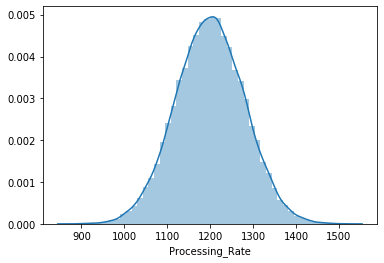

In [11]:
teste = PFI[(PFI['Site']==factory)]['Processing_Rate']
#Filtro o DataFrame

sns.distplot(teste)
print(f'Média de {teste.mean()}')
print(f'Desvio padrão de {teste.std()}')

In [12]:
equipment
#Temos 3 Equipamentos

,Number of RMI Drums,Number of PF Drums,Number of Pre-finish operation equipment,Number of PI Drums,Bag Machines,Box Machines
Manufacturing Facility,,,,,,
"Detroit, MI",40,15,2,8,1,1
"Columbus, OH",30,32,3,10,2,1
"Springfield, MO",50,24,1,15,1,1
"Green Bay, WI",20,17,2,17,1,1
"Omaha, NE",30,28,3,12,1,1


In [13]:
pi_drum[pi_drum['Site']==factory]

,Site,Drum Number,Capacity
50,"Omaha, NE",FI Drum 1,"17,500"
51,"Omaha, NE",FI Drum 2,"17,500"
52,"Omaha, NE",FI Drum 3,"17,500"
53,"Omaha, NE",FI Drum 4,"17,500"
54,"Omaha, NE",FI Drum 5,"17,500"
55,"Omaha, NE",FI Drum 6,"17,500"
56,"Omaha, NE",FI Drum 7,"17,500"
57,"Omaha, NE",FI Drum 8,"17,500"
58,"Omaha, NE",FI Drum 9,"17,500"
59,"Omaha, NE",FI Drum 10,"17,500"


## Packaging

In [14]:
#Temos 2 Bags e 1 Box
#Box line tem prefência sobre Bag (SimPY)
equipment

,Number of RMI Drums,Number of PF Drums,Number of Pre-finish operation equipment,Number of PI Drums,Bag Machines,Box Machines
Manufacturing Facility,,,,,,
"Detroit, MI",40,15,2,8,1,1
"Columbus, OH",30,32,3,10,2,1
"Springfield, MO",50,24,1,15,1,1
"Green Bay, WI",20,17,2,17,1,1
"Omaha, NE",30,28,3,12,1,1


Média de 3184.7034
Desvio padrão de 398.81244025348565


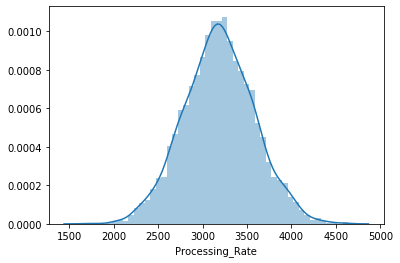

In [15]:
tipo = 'Bag' # 'Box'
teste2= packaging[(packaging['Site']==factory) & (packaging['Packaging_Type']==tipo)]['Processing_Rate']
#Filtro o DataFrame

sns.distplot(teste2)
print(f'Média de {teste2.mean()}')
print(f'Desvio padrão de {teste2.std()}')

In [16]:
pounds

,Pounds
Type,
Bag,0.25
Box,2.50


### Cria o DataFrame Auxiliar

In [17]:
# AUTOMATIZAR A DECLARAÇÃO DE PFI EQUIPMENTS PARA CADA FABRICA

machines = equipment[equipment.index==factory]['Number of Pre-finish operation equipment'][0]
pfi_names = []
for i in range(machines):
    pfi_names.append('PFI_'+str(i+1))

pfi_eq_aux = pd.DataFrame({'PFI': pfi_names, 'Sabor': "",'Ocupado':0 ,'Num':np.arange(machines), 'Ultimo_uso':0})
pfi_eq_aux.set_index('PFI',inplace=True)
pfi_eq_aux

,Sabor,Ocupado,Num,Ultimo_uso
PFI,,,,
PFI_1,,0,0,0
PFI_2,,0,1,0
PFI_3,,0,2,0


In [18]:
pfi_drum_aux = pfi_drum[pfi_drum['Site']==factory].replace({'Drum Number': " ", 'Capacity In pounds':','},{'Drum Number': "_", 'Capacity In pounds':''},regex=True).drop(['Site'],axis=1).astype({'Capacity In pounds': 'int32'})
pfi_drum_aux['Level'] = 0
pfi_drum_aux['Cor'] = ''
pfi_drum_aux['Size'] = ''
pfi_drum_aux['Num'] = pfi_drum_aux['Drum Number'].apply(lambda x: int(x.split('PFI_Drum')[-1])-1)
pfi_drum_aux.set_index('Drum Number',inplace=True)
pfi_drum_aux.head()

,Capacity In pounds,Level,Cor,Size,Num
Drum Number,,,,,
PFI_Drum1,7500,0,,,0
PFI_Drum2,7500,0,,,1
PFI_Drum3,7500,0,,,2
PFI_Drum4,7500,0,,,3
PFI_Drum5,7500,0,,,4


In [19]:
fi_drum_aux = pi_drum[pi_drum['Site']==factory].replace({'Drum Number': ' ', 'Capacity':','}, {'Drum Number': '_', 'Capacity':''}, regex = True).astype({'Capacity': 'int32'})
fi_drum_aux['Level'] = 0
fi_drum_aux['Cor'] = ''
fi_drum_aux['Size'] = ''
fi_drum_aux['Flavor'] = ''
fi_drum_aux['Num'] = fi_drum_aux['Drum Number'].apply(lambda x: int(x.split('FI_Drum_')[-1])-1)
fi_drum_aux.set_index('Drum Number',drop=True, inplace = True)
fi_drum_aux.drop(['Site'],axis = 1, inplace = True)
fi_drum_aux

,Capacity,Level,Cor,Size,Flavor,Num
Drum Number,,,,,,
FI_Drum_1,17500,0,,,,0
FI_Drum_2,17500,0,,,,1
FI_Drum_3,17500,0,,,,2
FI_Drum_4,17500,0,,,,3
FI_Drum_5,17500,0,,,,4
FI_Drum_6,17500,0,,,,5
FI_Drum_7,17500,0,,,,6
FI_Drum_8,17500,0,,,,7
FI_Drum_9,17500,0,,,,8


### Começo o SimPY do Classifier

In [20]:
pfi_drum_aux

,Capacity In pounds,Level,Cor,Size,Num
Drum Number,,,,,
PFI_Drum1,7500,0,,,0
PFI_Drum2,7500,0,,,1
PFI_Drum3,7500,0,,,2
PFI_Drum4,7500,0,,,3
PFI_Drum5,7500,0,,,4
PFI_Drum6,7500,0,,,5
PFI_Drum7,7500,0,,,6
PFI_Drum8,7500,0,,,7
PFI_Drum9,7500,0,,,8


In [21]:
fi_drum_aux

,Capacity,Level,Cor,Size,Flavor,Num
Drum Number,,,,,,
FI_Drum_1,17500,0,,,,0
FI_Drum_2,17500,0,,,,1
FI_Drum_3,17500,0,,,,2
FI_Drum_4,17500,0,,,,3
FI_Drum_5,17500,0,,,,4
FI_Drum_6,17500,0,,,,5
FI_Drum_7,17500,0,,,,6
FI_Drum_8,17500,0,,,,7
FI_Drum_9,17500,0,,,,8


In [22]:
#Para Columbus, OH

#obs: Gerenciamento da fila dos PFI Eq, Evitar SETUP
#obs: Classificador esperar só até 5...
#obs: Ordem muito grande trava tudo
#obs: lidar com decimais

box_espera = 0 #Variavel auxiliar para controle das filas
bag_espera = 0
classificador_ocupado = 0
ordens_extras = pd.DataFrame(columns = workorder.columns) #tambor-morto
ordens_complementares = pd.DataFrame(columns = workorder.columns) #quebra de ordens
ondens_sem_mp = pd.DataFrame(columns = workorder.columns)
classifier_balance = []
fim_sim = 0


def embalador(env, fi_drum_aux, FI_Drum, workorder, ordem, packaging, pounds, Bag, Box):
    #new: packaging, pounds, bag, box
    global box_espera, bag_espera, fim_sim
    
    #print(f'\nEmbalador executando a ordem {ordem} em {env.now}')
    
    color = workorder.iloc[ordem,2]
    size = workorder.iloc[ordem,3]
    flavor = workorder.iloc[ordem,4]
    pack = workorder.iloc[ordem,5]
    qtd_proc = workorder.iloc[ordem,6]
    
    retirar = qtd_proc
    
    #Começo as condicionais das prefêrencias para requisitar a linha
    if len(workorder[(workorder['Color']==color)&(workorder['Size']==size)&(workorder['Flavor']==flavor)&(workorder['Stage']==5)].index) > 0:
        
        pack_5 = workorder[(workorder['Color']==color)&(workorder['Size']==size)&(workorder['Flavor']==flavor)&(workorder['Stage']==5)]['Packaging Type'].iloc[0]

        if pack == 'Box' and pack_5 == 'Box':
            #Linha está executando Box e requisita Box
            req_box = Box.request()
            yield req_box
            #print(f'Ordem {ordem} requisitou Box em {env.now}')

        elif pack == 'Box' and pack_5 == 'Bag':
            #Linha está executando Bag e requisita Box
            #print(f'Ordem {ordem} de Box esperando Bag finalizar em {env.now}')

            while len(workorder[(workorder['Color']==color)&(workorder['Size']==size)&(workorder['Flavor']==flavor)&(workorder['Stage']==5)&(workorder['Packaging Type']=='Bag')].index) > 0:
                #Esperar finalizar a ordem de Bag
                box_espera = 1
                yield env.timeout(1)

            req_box = Box.request()
            yield req_box
            #print(f'Ordem {ordem} requisitou Box em {env.now}')
            box_espera = 0

        elif pack == 'Bag' and pack_5 == 'Bag':
            #Linha está executando Bag e requisita Bag
            if box_espera == 1:
                #print(f'Ordem {ordem} de Bag esperando Box finalizar em {env.now}')

                while box_espera == 1 or len(workorder[(workorder['Color']==color)&(workorder['Size']==size)&(workorder['Flavor']==flavor)&(workorder['Stage']==5)&(workorder['Packaging Type']=='Box')].index) > 0:
                    #Espera que todas as box esperando sejam processadas primeiro, para depois requisitar o bag
                    bag_espera = 1
                    yield env.timeout(1)

            req_bag = Bag.request()
            yield req_bag
            #print(f'Ordem {ordem} requisitou Bag em {env.now}')
            bag_espera = 0

        elif pack == 'Bag' and pack_5 == 'Box':
            #Linha está executando Box e requisita Bag
            #print(f'Ordem {ordem} de Bag esperando Box finalizar em {env.now}')
            while len(workorder[(workorder['Color']==color)&(workorder['Size']==size)&(workorder['Flavor']==flavor)&(workorder['Stage']==5)&(workorder['Packaging Type']=='Box')].index) > 0:
                #Esperar finalizar a ordem e a fila de Box 
                bag_espera = 1
                yield env.timeout(1)
            req_bag = Bag.request()
            yield req_bag
            #print(f'Ordem {ordem} requisitou Bag em {env.now}')
            bag_espera = 0
        else:
            print(f'Ordem {ordem} erro 1 em {env.now}')
            
    else: #Sem sku diferente
        if pack == 'Bag':
            req_bag = Bag.request()
            yield req_bag
            #print(f'Ordem {ordem} requisitou Bag em {env.now}')
            
        elif pack == 'Box':
            req_box = Box.request()
            yield req_box
            #print(f'Ordem {ordem} requisitou Box em {env.now}')
        else:
            print(f'Ordem {ordem} erro 2 em {env.now}')
            
    workorder.at[ordem,'Stage']=5
    #print(f'\nOrdem {ordem} mudou para o Stage 5 em {env.now}')
    
    #Calculo qual o fi_drum devo processar
    fi_drum_n = fi_drum_aux[(fi_drum_aux['Cor']==color) & (fi_drum_aux['Size']==size) & (fi_drum_aux['Flavor']==flavor)]['Num'].iloc[0]

    while qtd_proc > FI_Drum[fi_drum_n].level:
        #Limpo o RMI caso o retirar seja maior do que sua nivel restante
        qtd_proc = qtd_proc-FI_Drum[fi_drum_n].level

        FI_Drum[fi_drum_n].get(FI_Drum[fi_drum_n].level)
        #print(f'Esvaziar o FI_Drum {fi_drum_n+1} para a ordem {ordem} em {env.now}')

        fi_drum_aux.iat[fi_drum_n,1] = 0
        fi_drum_aux.iat[fi_drum_n,2] = ''
        fi_drum_aux.iat[fi_drum_n,3] = ''
        fi_drum_aux.iat[fi_drum_n,4] = ''

        fi_drum_n = fi_drum_aux[(fi_drum_aux['Cor']==color) & (fi_drum_aux['Size']==size) & (fi_drum_aux['Flavor']==flavor)]['Num'].iloc[0]
        #calcula qual o rmi_drum
    
    #Esvaziamos o FI Drum
    
    FI_Drum[fi_drum_n].get(qtd_proc) # max(qtd_proc,FI_Drum[fi_drum_n].level)
    
    #print(f'Ordem {ordem} Retirando {qtd_proc} do FI_Drum {fi_drum_n+1} da cor {color} e tamanho {size} e sabor {flavor}  em {env.now}\n')
        
    #Registrar que esvaziamos o PFI Drum para liberar o Classifier
    
    if FI_Drum[fi_drum_n].level ==0:
        fi_drum_aux.iat[fi_drum_n,1] = 0
        fi_drum_aux.iat[fi_drum_n,2] = ''
        fi_drum_aux.iat[fi_drum_n,3] = ''
        fi_drum_aux.iat[fi_drum_n,4] = ''
    else:
        fi_drum_aux.iat[fi_drum_n,1] = FI_Drum[fi_drum_n].level
    
    #Supondo Normalidade e sem diferença entre os tamanhos, calcula o tempo
    serie_hist = packaging[(packaging['Site']==factory) & (packaging['Packaging_Type']==pack)]['Processing_Rate'] #Série Histórica
    tempo_packging = (60*retirar/np.random.normal(serie_hist.mean(),serie_hist.std()))
     
    #Passa o tempo:    
    #print(f'\nTempo de processamento no Embalador {tempo_packging} da ordem {ordem} em {env.now}\n')
    yield env.timeout(tempo_packging)
    
    #Calcular quantas bags e box foram produzidas e finaliza o processo
    #obs: Ver como 'lidar' quando a ultima Bag ou Box for preenchida parcialmente
    
    if pack == 'Bag':
        bag_num = retirar/pounds.loc['Bag','Pounds']
        
        workorder.at[ordem,'Stage']=6
        workorder.at[ordem,'Fim']=env.now
        #print(f'\nOrdem {ordem} mudou para o Stage 6 em {env.now}')
        
        workorder.at[ordem,'Produzido']= str(bag_num)+' bags'
        print(f'Ordem {ordem} produziu {bag_num} bags em {env.now}')  
        
        #Finaliza o processo
        Bag.release(req_bag)
    
    elif pack == 'Box':
        box_num = retirar/pounds.loc['Box','Pounds']
        
        workorder.at[ordem,'Stage']=6
        workorder.at[ordem,'Fim']=env.now
        print(f'\nOrdem {ordem} mudou para o Stage 6 em {env.now}')
        
        workorder.at[ordem,'Produzido']=str(box_num)+' boxes'
        #print(f'Ordem {ordem} produziu {box_num} boxes em {env.now}') 
        
        #Finaliza o processo
        Box.release(req_box)
        
    fim_sim = env.now
    
#-----------------------------------------------------------------------------------------------------------

def saborizador(env, PFI_Drum, FI_Drum, PFI_Eq, pfi_drum_aux, PFI, workorder, ordem, fi_drum_aux, packaging, pounds, Bag, Box):
    
    for i in range(len(pfi_eq_aux.index)):
    #Atualizo a tabela pfi_eq_aux
        if len(PFI_Eq[i].users)>0:
            pfi_eq_aux.iat[i,1] = 1
        else:
            pfi_eq_aux.iat[i,1] = 0
            
    print(f'\nSaborizador executando a ordem {ordem} em {env.now} \n')
    color = workorder.iloc[ordem,2]
    size = workorder.iloc[ordem,3] 
    flavor = workorder.iloc[ordem,4] 
    qtd_proc = workorder.iloc[ordem,6]
    
    #Qual PFI Equipment eu vou requisitar: ---------------------
    
    if len(pfi_eq_aux[pfi_eq_aux['Ocupado']==0].index)>0: #Tenho um ou mais livres
        
        if len(pfi_eq_aux[(pfi_eq_aux['Ocupado']==0) & (pfi_eq_aux['Sabor']==flavor)].index) > 0:
            #Verificar se há um livre com meu sabor:
            num = pfi_eq_aux[(pfi_eq_aux['Ocupado']==0) & (pfi_eq_aux['Sabor']==flavor)].iloc[0,2]
            
        else:
            #Requisito o primeiro livre
            num = pfi_eq_aux[pfi_eq_aux['Ocupado']==0].iloc[0,2]   
            
    else: #Todos ocupados
        if len(pfi_eq_aux[(pfi_eq_aux['Sabor']==flavor)].index) > 0:
            #Verificar se há um ocupado com meu sabor:
            num = pfi_eq_aux[(pfi_eq_aux['Sabor']==flavor)].iloc[0,2]
            
        else:
            e_fila = []
            for e in PFI_Eq:
                e_fila.append(len(e.queue))
            num = pd.Series(e_fila).idxmin()
            #Pego o com menor fila
        
    #print(f'Ordem {ordem} Usara o PFI Equipment {num+1} em {env.now}')
    
    with PFI_Eq[num].request() as req:
        yield req
        
        sabor_old = pfi_eq_aux[pfi_eq_aux['Num']==num]['Sabor'].iloc[0]
        ultimo_uso = pfi_eq_aux[pfi_eq_aux['Num']==num]['Ultimo_uso'].iloc[0]
        
        setup = max(5-(env.now - ultimo_uso),0) #Tempo que falta para completar o SETUP
        
        if flavor != sabor_old and setup>0:
            
            #print(f'Setup de {setup} min na ordem {ordem} pois {flavor} diferente de {sabor_old} em {env.now}')
            yield env.timeout(setup)
            
        pfi_eq_aux.iat[num,0] = flavor #Recebe o sabor
        pfi_eq_aux.iat[num,3] = env.now
        
        #Calculo o PFI_Drum que devo retirar
        #OBS: RETIRAR DE MAIS DE 1 Drum quando necessário
        
        qtd = qtd_proc
        
        if qtd > pfi_drum_aux[(pfi_drum_aux['Cor']==color) & (pfi_drum_aux['Size']==size)]['Level'].sum():
            1==1
            #Em teoria esse if nunca deveria acontecer
            
        pfi_drum_n = pfi_drum_aux[(pfi_drum_aux['Cor']==color) & (pfi_drum_aux['Size']==size)]['Num'].iloc[0]
        #print(f'Ordem {ordem} em {env.now} com pfi_drum_n {pfi_drum_n+1} e PFI_Drum[pfi_drum_n].level {PFI_Drum[pfi_drum_n].level}\n')
        
        #print(f'\nqtd {qtd} e level {PFI_Drum[pfi_drum_n].level}')
        
        while qtd > PFI_Drum[pfi_drum_n].level:
            #Limpo o RMI caso o retirar seja maior do que sua nivel restante
            qtd = qtd-PFI_Drum[pfi_drum_n].level

            PFI_Drum[pfi_drum_n].get(PFI_Drum[pfi_drum_n].level)
            #print(f'Esvaziar o PFI_Drum {pfi_drum_n+1} para a ordem {ordem} em {env.now}')
            
            pfi_drum_aux.iat[pfi_drum_n,1] = 0
            pfi_drum_aux.iat[pfi_drum_n,2] = ''
            pfi_drum_aux.iat[pfi_drum_n,3] = ''

            pfi_drum_n = pfi_drum_aux[(pfi_drum_aux['Cor']==color) & (pfi_drum_aux['Size']==size)]['Num'].iloc[0]
            #calcula qual o pfi_drum

        #Esvaziamos o drum
        PFI_Drum[pfi_drum_n].get(qtd) #max(qtd,PFI_Drum[pfi_drum_n].level)
        #print(f'\nRetirado {qtd} do PFI_Drum {pfi_drum_n+1} da cor {color} e tamanho {size} para a ordem {ordem} em {env.now}')
        
        if PFI_Drum[pfi_drum_n].level ==0:
            pfi_drum_aux.iat[pfi_drum_n,1] = 0
            pfi_drum_aux.iat[pfi_drum_n,2] = ''
            pfi_drum_aux.iat[pfi_drum_n,3] = ''
        else:
            pfi_drum_aux.iat[pfi_drum_n,1] = PFI_Drum[pfi_drum_n].level
        
        #mudo o estado da workorder para 3 = PFI_Eq REQUISITADO
        workorder.at[ordem,'Stage']=3
        #print(f'\nOrdem {ordem} mudou para o Stage 3')
        
        serie_hist = PFI[(PFI['Site']==factory)]['Processing_Rate'] #Série Histórica
        tempo_PFI = 60*qtd_proc/np.random.normal(serie_hist.mean(),serie_hist.std())
        
        #print(f'\nTempo de processamento no Saborizador {tempo_PFI} na ordem {ordem} em {env.now}\n')
        #Passa o tempo:
        yield env.timeout(tempo_PFI)
        
        qtd_lista = []
        
        #Verifico a capacidade rstante de FI Drums já preenchidos com a mesma cor, tamanho e sabor
        fi_drum_2 = fi_drum_aux[(fi_drum_aux['Cor']==color) & (fi_drum_aux['Size'] == size) & (fi_drum_aux['Flavor'] == flavor)]
        fi_drum_2.loc[:,'restante'] = fi_drum_2.loc[:,'Capacity'].add(-fi_drum_2.loc[:,'Level'])
        restante = fi_drum_2['restante'].sum()
        
        if restante >0:
            if restante >= qtd_proc:
                #Não precisa de novos FI Drums
                qtd_lista.append(qtd_proc)
                qtd_proc=0
            else:
                qtd_proc = qtd_proc - restante
                qtd_lista.append(restante)
        else:
            qtd_lista.append(None)
        
        while qtd_proc > FI_Drum[0].capacity:
            qtd_proc = qtd_proc - FI_Drum[0].capacity
            qtd_lista.append(FI_Drum[0].capacity)
            
        if qtd_proc >0:
            qtd_lista.append(qtd_proc)
        #Calculo quantos FI Drums eu vou precisar
        
        if len(fi_drum_aux[fi_drum_aux.Level==0].index) < (len(qtd_lista)-1):
            #print(f'Ordem {ordem} presa no Loop do Saborizador por Falta de FI Drum em {env.now}')   
            while len(fi_drum_aux[fi_drum_aux.Level==0].index) < (len(qtd_lista)-1):
                #Esperar até que haja 1 FI Drum Vazio
                yield env.timeout(1)
                
                qtd_lista = []
                #Verifico a capacidade rstante de FI Drums já preenchidos com a mesma cor, tamanho e sabor
                fi_drum_2 = fi_drum_aux[(fi_drum_aux['Cor']==color) & (fi_drum_aux['Size'] == size) & (fi_drum_aux['Flavor'] == flavor)]
                fi_drum_2.loc[:,'restante'] = fi_drum_2.loc[:,'Capacity'].add(-fi_drum_2.loc[:,'Level'])
                restante = fi_drum_2['restante'].sum()

                if restante >0:
                    if restante >= qtd_proc:
                        #Não precisa de novos FI Drums
                        qtd_lista.append(qtd_proc)
                        qtd_proc=0
                    else:
                        qtd_proc = qtd_proc - restante
                        qtd_lista.append(restante)
                else:
                    qtd_lista.append(None)

                while qtd_proc > FI_Drum[0].capacity:
                    qtd_proc = qtd_proc - FI_Drum[0].capacity
                    qtd_lista.append(FI_Drum[0].capacity)

                if qtd_proc >0:
                    qtd_lista.append(qtd_proc)
        
        if qtd_lista[0] != None:
            #Preenche primeiro o FI Drum com capacidade restante
            FI_n = fi_drum_aux[(fi_drum_aux['Cor']==color) & (fi_drum_aux['Level']< FI_Drum[0].capacity) & (fi_drum_aux['Size'] == size) & (fi_drum_aux['Flavor'] == flavor)]['Num'].iloc[0]
            FI_idx = fi_drum_aux[(fi_drum_aux['Cor']==color) & (fi_drum_aux['Level']< FI_Drum[0].capacity) & (fi_drum_aux['Size'] == size) & (fi_drum_aux['Flavor'] == flavor)]['Num'].index[0]
            
            while qtd_lista[0] > (FI_Drum[FI_n].capacity - FI_Drum[FI_n].level):
                #Limpo o RMI caso o retirar seja maior do que sua nivel restante
                qtd_lista[0] = qtd_lista[0]-(FI_Drum[FI_n].capacity - FI_Drum[FI_n].level)
                
                FI_Drum[FI_n].put((FI_Drum[FI_n].capacity - FI_Drum[FI_n].level))
                #print(f'Preencher FI_Drum {FI_n+1} de level {FI_Drum[FI_n].level} com {qtd_lista[0]} para ordem {ordem} em {env.now}')

                fi_drum_aux.at[FI_idx,'Level'] = FI_Drum[FI_n].level 
                
                FI_n = fi_drum_aux[(fi_drum_aux['Cor']==color) & (fi_drum_aux['Level']< FI_Drum[0].capacity) & (fi_drum_aux['Size'] == size) & (fi_drum_aux['Flavor'] == flavor)]['Num'].iloc[0]
                FI_idx = fi_drum_aux[(fi_drum_aux['Cor']==color) & (fi_drum_aux['Level']< FI_Drum[0].capacity) & (fi_drum_aux['Size'] == size) & (fi_drum_aux['Flavor'] == flavor)]['Num'].index[0]

            FI_Drum[FI_n].put(qtd_lista[0])
            #print(f'Preencher FI_Drum {FI_n+1} de level {FI_Drum[FI_n].level} com {qtd_lista[0]} para ordem {ordem} em {env.now}')
            fi_drum_aux.at[FI_idx,'Level'] = FI_Drum[FI_n].level 
            
        retirar = pd.Series(qtd_lista[1:]).sum()
        
        if retirar >0:
            #Calcula o FI Drum a ser abastecido        
            FI_n = fi_drum_aux[fi_drum_aux['Level']==0]['Num'].iloc[0]
            FI_idx = fi_drum_aux[fi_drum_aux['Level']==0]['Num'].index[0]

            while retirar > FI_Drum[FI_n].capacity:
                #Realiza a repartição do retirar
                retirar = retirar-FI_Drum[FI_n].capacity

                FI_Drum[FI_n].put(FI_Drum[FI_n].capacity)
                print(f'Preencher FI_Drum {FI_n+1} com {FI_Drum[FI_n].capacity} para ordem {ordem} em {env.now}')

                fi_drum_aux.at[FI_idx,'Cor'] = color
                fi_drum_aux.at[FI_idx,'Size'] = size
                fi_drum_aux.at[FI_idx,'Flavor'] = flavor
                fi_drum_aux.at[FI_idx,'Level'] = FI_Drum[FI_n].capacity

                FI_n = fi_drum_aux[fi_drum_aux['Level']==0]['Num'].iloc[0]
                FI_idx = fi_drum_aux[fi_drum_aux['Level']==0]['Num'].index[0]

            #print(f'Preencher FI_Drum {FI_n+1} com {retirar} para ordem {ordem}  em {env.now}\n')
            #Encho o FI_Drum
            FI_Drum[FI_n].put(retirar)

            fi_drum_aux.at[FI_idx,'Cor'] = color
            fi_drum_aux.at[FI_idx,'Size'] = size
            fi_drum_aux.at[FI_idx,'Flavor'] = flavor
            fi_drum_aux.at[FI_idx,'Level'] = retirar
        
        #Passa para o Stage 4 quem passou pelo PFI
        workorder.at[ordem,'Stage']=4
        #print(f'\nOrdem {ordem} mudou para o Stage 4 em {env.now}')

        #CHAMAR O PACKAGING
        env.process(embalador(env, fi_drum_aux, FI_Drum, workorder, ordem, packaging, pounds, Bag, Box))
        
#-----------------------------------------------------------------------------------------------------------
    
def classificador (env, classifier, classifier_rates, split, RMI_DRUM, PFI_Drum, qtd, color, pfi_drum_aux, workorder, ordem, FI_Drum, PFI_Eq, PFI, fi_drum_aux, packaging, pounds, Bag, Box):
    global ordens_extras, ordens_complementares, classificador_ocupado, classifier_balance
    
    #print(f'\nClassificador executando a ordem {ordem} em {env.now}')
    classifier_balance.append([factory, color, qtd])
    
    if qtd > 0:
        #Só ativa o Classifier se necessário
        
        qtd_time = qtd
        
        req_classifier = classifier.request()
        #Requisita o classificador somente se necessário
        yield req_classifier
        classificador_ocupado = 1

        #mudo o estado da workorder para 1 = CLASSIFICADOR REQUISITADO

        rmi_drum_idx = RMI[(RMI['Location Name']==factory) & (RMI['Color'] == color) & (RMI['Qty in pounds'] > 0)].index[0]
        rmi_drum_n = RMI[(RMI['Location Name']==factory) & (RMI['Color'] == color) & (RMI['Qty in pounds'] > 0)].iloc[0,5]
        #calcula qual o rmi_drum

        while qtd > RMI_DRUM[rmi_drum_n].level:
            #Limpo o RMI caso o retirar seja maior do que sua nivel restante
            qtd = qtd-RMI_DRUM[rmi_drum_n].level

            RMI_DRUM[rmi_drum_n].get(RMI_DRUM[rmi_drum_n].level)
            print(f'Esvaziar o RMI_Drum {rmi_drum_n+1} para a ordem {ordem} em {env.now}')

            RMI.at[rmi_drum_idx,'Color'] = ''
            RMI.at[rmi_drum_idx,'Qty in pounds'] = 0

            rmi_drum_idx = RMI[(RMI['Location Name']==factory) & (RMI['Color'] == color) & (RMI['Qty in pounds'] > 0)].index[0]
            rmi_drum_n = RMI[(RMI['Location Name']==factory) & (RMI['Color'] == color) & (RMI['Qty in pounds'] > 0)].iloc[0,5]
            #calcula qual o rmi_drum

        RMI_DRUM[rmi_drum_n].get(qtd)
        #print(f'\nRetirado {qtd} do RMI_Drum {rmi_drum_n+1} para a ordem {ordem} em {env.now}')
        #Retira do RMI especificado a qtd necessária

        if RMI_DRUM[rmi_drum_n].level ==0:
            RMI.at[rmi_drum_idx,'Qty in pounds'] = 0
            RMI.at[rmi_drum_idx,'Color'] = ''
        else:
            RMI.at[rmi_drum_idx,'Qty in pounds'] = RMI_DRUM[rmi_drum_n].level

        tempo_classifier = (qtd_time/classifier_rates[classifier_rates['Site']==factory].iloc[0,2])*60
        #print(f'\nTempo de processamento no Classificador {tempo_classifier} na ordem {ordem} em {env.now}\n')
        yield env.timeout(tempo_classifier)
        #Passa o tempo em minutos
        classificador_ocupado = 0
        
        divisao = split[(split['Color ']==color)].sort_values(by=['Size']).set_index('Size')['Percentage ']*qtd_time/100
        divisao = divisao.apply(np.floor)
        #Calcula o percentual divido de cada um dos cinco tamanhos em pounds e enche os 5 PFI Drums
        
        #Verifico a capacidade rstante de PFI Drums já preenchidos com a mesma cor
        pfi_drum_2 = pfi_drum_aux[(pfi_drum_aux['Cor']==color)]
        pfi_drum_2.loc[:,'restante'] = (pfi_drum_2.loc[:,'Capacity In pounds']*0.95).add(-pfi_drum_2.loc[:,'Level'])
        pfi_drum_2 = pfi_drum_2.groupby('Size').sum()['restante']

        divisao2 = divisao.add(-pfi_drum_2, fill_value=0)
        divisao2 = divisao2[divisao2>0]
        #Calculo quanto eu precisaria encher de cada tamanho após usar os já preenchidos
        #print(f'ordem{ordem} e divisao2 \n{divisao2}')

        divisao3 = divisao.add(-divisao2, fill_value=0)
        divisao3 = divisao3[divisao3>0]            
        #Calculo quanto eu preciso encher nos PFI Drums já preenchidos
        
        #print(f'\n{divisao3}')
                
        rest= pd.Series([])
        #print(divisao2)
        
        for i in divisao2.index:
            #Caso precise de mais de 5 tambores
            while divisao2[i] > 0.95*PFI_Drum[0].capacity:
                divisao2[i] = divisao2[i] - 0.95*PFI_Drum[0].capacity
                rest = rest.append(pd.Series([0.95*PFI_Drum[0].capacity],index=[i]))
        divisao2 = divisao2.append(rest)
        
        #Espera até que haja 5 ou mais PFI Drums vazios
        if len(pfi_drum_aux[pfi_drum_aux.Level==0].index) < len(divisao2):
            
            print(f'\nOrdem {ordem} presa no Loop do Classificador por Falta de PFI Drum em {env.now}')
            #Saber se é uma morte momentanea ou definitiva
            
            usara = workorder[(workorder['Stage']==2)].copy()
            #usara são as ordens na fila da saborização

            pfi_futuro = pfi_drum_aux.copy()
            #pfi_futuro será o pfi_drum_aux após a execução das ordens na fila da saborização

            for i in usara.index:
                uso = usara.loc[i,'Qty']

                pfi_drum_n = pfi_futuro[(pfi_futuro['Cor']==usara.loc[i,'Color']) & (pfi_futuro['Size']==usara.loc[i,'Size'])]['Num'].iloc[0]

                while uso > pfi_futuro.iloc[pfi_drum_n].Level:

                    uso = uso-pfi_futuro.iloc[pfi_drum_n].Level
                    #print(f'\n[PMP] o PFI_Drum {pfi_drum_n+1} será esvaziado na ordem {i}')

                    pfi_futuro.iat[pfi_drum_n,1] = 0
                    pfi_futuro.iat[pfi_drum_n,2] = ''
                    pfi_futuro.iat[pfi_drum_n,3] = ''

                    pfi_drum_n = pfi_futuro[(pfi_futuro['Cor']==usara.loc[i,'Color']) & (pfi_futuro['Size']==usara.loc[i,'Size'])]['Num'].iloc[0]

                if (pfi_futuro.iloc[pfi_drum_n].Level - uso)==0:
                    #print(f'\n[PMP] o PFI_Drum {pfi_drum_n+1} será esvaziado na ordem {i}')
                    pfi_futuro.iat[pfi_drum_n,1] = 0
                    pfi_futuro.iat[pfi_drum_n,2] = ''
                    pfi_futuro.iat[pfi_drum_n,3] = ''
                else:
                    pfi_futuro.iat[pfi_drum_n,1] = pfi_futuro.iloc[pfi_drum_n].Level - uso

            pfi_futuro['Stage_Faltante'] = pfi_futuro.apply(lambda x: workorder[(workorder['Color']==x['Cor']) & (workorder['Size']==x['Size'])]['Stage'].min(), axis=1)
            #Tambores com stage faltante >=2 são mortos, pois já tiveram seus gets contabilizados no pfi_futuro. O resto é lixo (vivo)
            
            pfi_drum_2_futuro = pfi_futuro[(pfi_futuro['Cor']==color)].copy()
            pfi_drum_2_futuro['restante'] = pfi_drum_2_futuro.apply(lambda x: x['Capacity In pounds']*0.95 - x['Level'],axis=1,result_type='reduce')
            pfi_drum_2_futuro = pfi_drum_2_futuro.groupby('Size').sum()['restante']

            divisao2_futuro = divisao.add(-pfi_drum_2_futuro, fill_value=0)
            divisao2_futuro = divisao2_futuro[divisao2_futuro>0]

            divisao3_futuro = divisao.add(-divisao2_futuro, fill_value=0)
            divisao3_futuro = divisao3_futuro[divisao3_futuro>0]

            rest= pd.Series([])
            for i in divisao2_futuro.index:
                #Caso precise de mais de 5 tambores
                while divisao2_futuro[i] > 0.95*PFI_Drum[0].capacity:
                    divisao2_futuro[i] = divisao2_futuro[i] - 0.95*PFI_Drum[0].capacity
                    rest = rest.append(pd.Series([0.95*PFI_Drum[0].capacity],index=[i]))
            divisao2_futuro = divisao2_futuro.append(rest)
                
            if len(divisao2_futuro) <= len(pfi_futuro[pfi_futuro.Level==0].index):
                print(f'\nMorte momentanea na ordem {ordem} em {env.now}')
            
            else:
                preciso_liberar = len(divisao2_futuro) - len(pfi_futuro[pfi_futuro.Level==0].index) #Target
                print(f'\nMorte definitiva na ordem {ordem} em {env.now} que precisa liberar {preciso_liberar} pfi drums')
            
                #Criar uma ordem para esvaziar esses tambores
                tambores_mortos = pfi_futuro[(pfi_futuro['Level'] > 0) & (pfi_futuro['Stage_Faltante']>=2)].iloc[:preciso_liberar]
                
                workorder_fantasma = pd.DataFrame(data={'Color':tambores_mortos['Cor'], 'Size':tambores_mortos['Size'], 'Qty':tambores_mortos['Level'], 'Plant Id':factory, 'Flavor': workorder.iloc[ordem,4],'Packaging Type':'Bag', 'Stage':2},columns = workorder.columns)
                ordem_fantasma = np.arange(len(tambores_mortos.index)) + len(workorder.index)
                workorder_fantasma.index = ordem_fantasma
                print(f'\n workorder_fantasma para ordem {ordem} em {env.now} \n{workorder_fantasma}')

                ordens_extras = ordens_extras.append(workorder_fantasma)

                for i in ordem_fantasma:
                    #Envio as ordens fantasmas
                    workorder.loc[i] = list(workorder_fantasma.loc[i])
                    env.process(saborizador(env, PFI_Drum, FI_Drum, PFI_Eq, pfi_drum_aux, PFI, workorder, i, fi_drum_aux, packaging, pounds, Bag, Box))
            
            while len(pfi_drum_aux[pfi_drum_aux.Level==0].index) < len(divisao2):
                #Durante esse tempo alguns PFI Drums contendo a mesma cor parcialemente cheios podem ter capacidade 'liberada'
                yield env.timeout(1)
                
                pfi_drum_2 = pfi_drum_aux[(pfi_drum_aux['Cor']==color)]
                pfi_drum_2.loc[:,'restante'] = (pfi_drum_2.loc[:,'Capacity In pounds']*0.95).add(-pfi_drum_2.loc[:,'Level'])
                pfi_drum_2 = pfi_drum_2.groupby('Size').sum()['restante']
                
                #print(f'ordem {ordem} em {env.now}\n e \n{pfi_drum_aux}') #TINHA 5 restante

                divisao2 = divisao.add(-pfi_drum_2, fill_value=0)
                divisao2 = divisao2[divisao2>0]

                divisao3 = divisao.add(-divisao2, fill_value=0)
                divisao3 = divisao3[divisao3>0]
                
                rest= pd.Series([])
                #print(divisao2)

                for i in divisao2.index:
                    #Caso precise de mais de 5 tambores
                    while divisao2[i] > 0.95*PFI_Drum[0].capacity:
                        divisao2[i] = divisao2[i] - 0.95*PFI_Drum[0].capacity
                        rest = rest.append(pd.Series([0.95*PFI_Drum[0].capacity],index=[i]))
                divisao2 = divisao2.append(rest)            
              
        for z in range(len(divisao3)):
            
            parcial = math.floor(divisao3[z])
            
            try:
                pfi_n = pfi_drum_aux[(pfi_drum_aux['Cor']==color) & (pfi_drum_aux['Level']< PFI_Drum[0].capacity*0.95) & (pfi_drum_aux['Size']==divisao3.index[z])]['Num'].iloc[0]
                pfi_idx = pfi_drum_aux[(pfi_drum_aux['Cor']==color)& (pfi_drum_aux['Level']< PFI_Drum[0].capacity*0.95) & (pfi_drum_aux['Size']==divisao3.index[z])].iloc[0].name
            except:
                pfi_n= pfi_drum_aux[(pfi_drum_aux['Level']==0)]['Num'].iloc[0]
                pfi_idx= pfi_drum_aux[(pfi_drum_aux['Level']==0)]['Num'].index[0]
            
            while parcial > (PFI_Drum[pfi_n].capacity*0.95 - PFI_Drum[pfi_n].level):
                #Realiza a repartição do parcial
                parcial = parcial-(PFI_Drum[pfi_n].capacity*0.95 - PFI_Drum[pfi_n].level)

                PFI_Drum[pfi_n].put((PFI_Drum[pfi_n].capacity*0.95 - PFI_Drum[pfi_n].level))
                pfi_drum_aux.at[pfi_idx, 'Level']= PFI_Drum[pfi_n].capacity*0.95
                pfi_drum_aux.at[pfi_idx, 'Cor']= color
                pfi_drum_aux.at[pfi_idx, 'Size']= divisao3.index[z]
                
                try:
                    pfi_n = pfi_drum_aux[(pfi_drum_aux['Cor']==color) & (pfi_drum_aux['Level']< PFI_Drum[0].capacity*0.95) & (pfi_drum_aux['Size']==divisao3.index[z])]['Num'].iloc[0]
                    pfi_idx = pfi_drum_aux[(pfi_drum_aux['Cor']==color) & (pfi_drum_aux['Level']< PFI_Drum[0].capacity*0.95) & (pfi_drum_aux['Size']==divisao3.index[z])].iloc[0].name
                except:
                    pfi_n= pfi_drum_aux[(pfi_drum_aux['Level']==0)]['Num'].iloc[0]
                    pfi_idx= pfi_drum_aux[(pfi_drum_aux['Level']==0)]['Num'].index[0]

            PFI_Drum[pfi_n].put(parcial)
            pfi_drum_aux.at[pfi_idx, 'Level']= PFI_Drum[pfi_n].level
            pfi_drum_aux.at[pfi_idx, 'Cor']= color
            pfi_drum_aux.at[pfi_idx, 'Size']= divisao3.index[z]
        
        #print(f'ordem {ordem} em {env.now} com divisao2 \n{divisao2}')

        for x in range(len(divisao2)):
            PFI_Drum[pfi_drum_aux[pfi_drum_aux.Level==0].iloc[x,4]].put(math.floor(divisao2.iloc[x]))
            #Preencher primeiro o PFI Drum de menor número (mais vazio) -- FEITO
            
        for y in range(len(divisao2)): 
            #Alimento a planilha auxiliar
            pfi_drum_aux.at[pfi_drum_aux[pfi_drum_aux.Level==0].iloc[0].name, 'Cor']= color
            pfi_drum_aux.at[pfi_drum_aux[pfi_drum_aux.Level==0].iloc[0].name, 'Size']= list(divisao2.index)[y]
            pfi_drum_aux.at[pfi_drum_aux[pfi_drum_aux.Level==0].iloc[0].name, 'Level']= math.floor(divisao2.iloc[y])
        
        classifier.release(req_classifier)
        #Libera o Classifier
        
    else:
        1==1
        #print(f'\nOrdem {ordem} já possuia classificado o que precisava em {env.now}')
        
    #mudo o estado da workorder para 2 = PFI DRUM PREENCHIDO
    workorder.at[ordem,'Stage']=2
    print(f'\nOrdem {ordem} mudou para o Stage 2 em {env.now}')

    #CHAMAR O PI OPERATION
    env.process(saborizador(env, PFI_Drum, FI_Drum, PFI_Eq, pfi_drum_aux, PFI, workorder, ordem, fi_drum_aux,packaging, pounds, Bag, Box))

#-----------------------------------------------------------------------------------------------------------
            
# Função executora de Workorders
def workorder_exe(env, workorder, split, RMI, classifier_rates, classifier, RMI_DRUM, PFI_Drum, pfi_drum_aux, FI_Drum, PFI_Eq, PFI, fi_drum_aux,packaging, pounds, Bag, Box):
    global ondens_sem_mp
    for ordem in workorder.index:
        #Pula a ordem se não houver a cor
        
        while len(workorder[workorder['Stage']==1]) > 0:
            #Espera o classificador ser liberado
            yield env.timeout(1)
            
        workorder.at[ordem,'Stage']=0
        #Mudaria o Stage da primeira workorder

        color = workorder.iloc[ordem,2]
        size = workorder.iloc[ordem,3]
        qtd_proc = workorder.iloc[ordem,6] #2 Casas decimais

        #Verifico o que já tenho classificado dessa cor e tamanho
        qtd_classificado = pfi_drum_aux[(pfi_drum_aux['Cor'] == color) & (pfi_drum_aux['Size'] == size)]['Level'].sum()

        qtd_a_ser_usado = workorder[(workorder['Stage']==2) & (workorder['Color']== color) & (workorder['Size']== size)]['Qty'].sum()
        #Podem ter ordens no Stage 2 que foram classificadas mais ainda não fizeram o seus gets dos PFIs

        liberado = qtd_classificado - qtd_a_ser_usado

        if liberado >0:
            #Calculo apenas o necessario para complementar o que já tenho
            qtd_proc = max(qtd_proc - liberado,0)

        qtd = math.ceil(qtd_proc/(split[(split['Color ']== color) & (split['Size']== size)].iloc[0,2]/100))
        #calcula a quantidade a ser retirada do RMI (SOMENTE O NECESSÁRIO)

        disponivel = RMI[(RMI['Location Name']==factory) & (RMI['Color'] == color)]['Qty in pounds'].sum()

        if disponivel >= qtd:
            
            env.process(classificador(env, classifier, classifier_rates, split, RMI_DRUM, PFI_Drum, qtd, color, pfi_drum_aux, workorder, ordem, FI_Drum, PFI_Eq, PFI, fi_drum_aux,packaging, pounds, Bag, Box))

            workorder.at[ordem,'Stage']=1
            workorder.at[ordem,'Inicio']=env.now
            #print(f'\nOrdem {ordem} mudou para o Stage 1 em {env.now}\nE pegará {qtd} da cor {color} na fabrica {factory} que disponivel {disponivel}')

        elif disponivel>0:
            #Gerar ordem incompleta:
            posso_clas = split[(split['Color ']==color)].sort_values(by=['Size']).set_index('Size')['Percentage ']*disponivel/100
            posso_clas = posso_clas.apply(np.floor)

            falta_proc = qtd_proc - posso_clas[size]
            workorder_complementar = workorder.loc[ordem].copy()

            workorder.at[ordem,'Stage']= 1
            workorder.at[ordem,'Inicio']= env.now
            workorder.at[ordem,'Qty'] = posso_clas[size] + liberado
            env.process(classificador(env, classifier, classifier_rates, split, RMI_DRUM, PFI_Drum, disponivel, color, pfi_drum_aux, workorder, ordem, FI_Drum, PFI_Eq, PFI, fi_drum_aux,packaging, pounds, Bag, Box))
            #print(f'\nOrdem {ordem} foi quebrada com {posso_clas[size] + liberado} e mudou para o Stage 1 em {env.now} e o disponivel {disponivel}')

            workorder_complementar.at['Qty'] = falta_proc
            ordem_complementar = len(workorder.index)
            workorder_complementar.at['Stage'] = 99
            workorder.loc[ordem_complementar] = workorder_complementar
            #adiciono ela no pmp_mae
            ondens_sem_mp = ondens_sem_mp.append(workorder_complementar,sort=False)
        else:
            #print(f'\nOrdem {ordem} não atendida pois necessita {qtd} e há disponivel {disponivel} da cor {color} na fabrica {factory} em {env.now}')
            workorder.at[ordem,'Stage']=99
            ondens_sem_mp = ondens_sem_mp.append(workorder.iloc[ordem],sort=False)
            
        yield env.timeout(1)
            
tamanho_da_fila_clas = []
tamanho_da_fila_pfi = []
tamanho_da_fila_bag = []
tamanho_da_fila_box = []

ociosidade_classifier = []
ociosidade_saborizador = []
ociosidade_embalador_Box=[]
ociosidade_embalador_Bag=[]
#-----------------------------------------------------------------------------------------------------------

# Função observadora do processo
def observador(env, classifier, PFI_Eq, Bag, Box):
    while True:
        tamanho_da_fila_clas.append(len(classifier.queue)) #Não me diz muito
        ociosidade_classifier.append(classificador_ocupado)
        
        lista = []
        lista2 = []
        for i in range(len(PFI_Eq)):
            lista.append(len(PFI_Eq[i].queue))
            lista2.append(PFI_Eq[i].count)
            
        tamanho_da_fila_pfi.append(lista)
        ociosidade_saborizador.append(lista2)
        
        
        tamanho_da_fila_bag.append(len(Bag.queue)+bag_espera)
        tamanho_da_fila_box.append(len(Box.queue)+box_espera)
        ociosidade_embalador_Box.append(Box.count)
        ociosidade_embalador_Bag.append(Bag.count)
        
        yield env.timeout(1)

In [23]:
env = simpy.Environment()

#DECLARO OS PFI DRUMS ITERATIVAMENTE E ARMAZENO ELES NUMA LISTA
PFI_Drum = []
a = dict(pfi_drum[pfi_drum['Site']==factory].replace({'Drum Number': " ", 'Capacity In pounds':','},{'Drum Number': "_", 'Capacity In pounds':''},regex=True).set_index('Drum Number').astype({'Capacity In pounds': 'int32'})['Capacity In pounds'])
for key,val in a.items():
        exec(key + '= simpy.Container(env, capacity = val, init=0)')
        exec('PFI_Drum.append(' + key+')')

#DECLARO OS PI DRUMS ITERATIVAMENTE E ARMAZENO ELES NUMA LISTA
FI_Drum = []
b = dict(pi_drum[pi_drum['Site']==factory].replace({'Drum Number': ' ', 'Capacity':','}, {'Drum Number': '_', 'Capacity':''}, regex = True).astype({'Capacity': 'int32'}).set_index('Drum Number')['Capacity'])
for key,val in b.items():
        exec(key + '= simpy.Container(env, capacity = val, init=0)')
        exec('FI_Drum.append(' + key+')')

#DECLARO OS RMI DRUMS ITERATIVAMENTE E ARMAZENO ELES NUMA LISTA
RMI_DRUM = []
c = RMI[RMI['Location Name']==factory].replace({'RMI Drum': ' ', 'Capacity':','}, {'RMI Drum': '_', 'Capacity':''}, regex = True).astype({'Capacity': 'int32'}).set_index('RMI Drum')[['Qty in pounds','Capacity']].to_dict('index')
for key in c.keys():
    val = c[key]['Qty in pounds']
    val2 = c[key]['Capacity']
    exec(key + '= simpy.Container(env, capacity = val2, init=val)')
    exec('RMI_DRUM.append(' + key+')')

#Declaro o Classifier
classifier = simpy.Resource(env, capacity=1)

#Declaro os PI Equipments ITERATIVAMENTE
PFI_Eq = []
for key in range(equipment[equipment.index==factory]['Number of Pre-finish operation equipment'].iloc[0]):
    exec('PFI_'+str(key)+' = simpy.Resource(env, capacity = 1)')
    exec('PFI_Eq.append(PFI_'+str(key)+')')

#Declarar os Packaging:

Bag = simpy.Resource(env, capacity = equipment[equipment.index==factory]['Bag Machines'].iloc[0])
Box = simpy.Resource(env, capacity = equipment[equipment.index==factory]['Box Machines'].iloc[0])

In [24]:
env.process(workorder_exe(env, workorder, split, RMI, classifier_rates, classifier, RMI_DRUM, PFI_Drum, pfi_drum_aux, FI_Drum, PFI_Eq, PFI, fi_drum_aux, packaging, pounds, Bag, Box))
env.process(observador(env, classifier, PFI_Eq, Bag, Box))
env.run(until=300000) #262620


Ordem 0 mudou para o Stage 2 em 305.8378378378378

Saborizador executando a ordem 0 em 305.8378378378378 


Ordem 1 mudou para o Stage 2 em 306

Saborizador executando a ordem 1 em 306 


Ordem 2 mudou para o Stage 2 em 307

Saborizador executando a ordem 2 em 307 


Ordem 3 mudou para o Stage 2 em 308

Saborizador executando a ordem 3 em 308 


Ordem 4 mudou para o Stage 2 em 309

Saborizador executando a ordem 4 em 309 


Ordem 5 mudou para o Stage 2 em 310

Saborizador executando a ordem 5 em 310 


Ordem 6 mudou para o Stage 2 em 311

Saborizador executando a ordem 6 em 311 


Ordem 2 mudou para o Stage 6 em 350.6561043853452
Ordem 0 produziu 14484.0 bags em 542.7567610262319
Ordem 5 produziu 13480.0 bags em 600.6420651927492
Ordem 1 produziu 15508.0 bags em 677.4141112334413

Ordem 7 mudou para o Stage 2 em 710.8243243243244

Saborizador executando a ordem 7 em 710.8243243243244 



C:\Users\monke\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\monke\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s



Ordem 8 mudou para o Stage 2 em 711

Saborizador executando a ordem 8 em 711 


Ordem 9 mudou para o Stage 2 em 712

Saborizador executando a ordem 9 em 712 


Ordem 10 mudou para o Stage 2 em 713

Saborizador executando a ordem 10 em 713 


Ordem 11 mudou para o Stage 2 em 714

Saborizador executando a ordem 11 em 714 

Ordem 4 produziu 7748.0 bags em 719.1312439760135

Ordem 12 mudou para o Stage 2 em 729.7837837837837

Saborizador executando a ordem 12 em 729.7837837837837 


Ordem 13 mudou para o Stage 2 em 730

Saborizador executando a ordem 13 em 730 


Ordem 14 mudou para o Stage 2 em 731

Saborizador executando a ordem 14 em 731 


Ordem 15 mudou para o Stage 2 em 732

Saborizador executando a ordem 15 em 732 


Ordem 16 mudou para o Stage 2 em 733

Saborizador executando a ordem 16 em 733 


Ordem 17 mudou para o Stage 2 em 734

Saborizador executando a ordem 17 em 734 


Ordem 18 mudou para o Stage 2 em 735

Saborizador executando a ordem 18 em 735 


Ordem 19 mudou para o S

Ordem 60 produziu 11304.0 bags em 3366.2680371475044
Ordem 65 produziu 18932.0 bags em 3458.0423676175233
Ordem 63 produziu 12296.0 bags em 3516.069482768062

Ordem 67 mudou para o Stage 6 em 3557.523826499746

Ordem 68 mudou para o Stage 2 em 3563.0405405405404

Saborizador executando a ordem 68 em 3563.0405405405404 


Ordem 69 mudou para o Stage 2 em 3564

Saborizador executando a ordem 69 em 3564 


Ordem 70 mudou para o Stage 2 em 3565

Saborizador executando a ordem 70 em 3565 

Ordem 64 produziu 14976.0 bags em 3590.051265769043
Ordem 66 produziu 9796.0 bags em 3642.3571732855316
Ordem 68 produziu 9932.0 bags em 3727.4669125228943

Ordem 70 mudou para o Stage 6 em 3757.9343071308344

Ordem 69 mudou para o Stage 6 em 3804.643630910557

Ordem 71 mudou para o Stage 2 em 3891.310810810811

Saborizador executando a ordem 71 em 3891.310810810811 


Ordem 72 mudou para o Stage 2 em 3892

Saborizador executando a ordem 72 em 3892 


Ordem 73 mudou para o Stage 2 em 3893

Saborizador exe

Ordem 99 produziu 28500.0 bags em 7325.176362819124

Ordem 136 mudou para o Stage 2 em 7365.0

Saborizador executando a ordem 136 em 7365.0 


Ordem 137 mudou para o Stage 2 em 7365

Saborizador executando a ordem 137 em 7365 


Ordem 138 mudou para o Stage 2 em 7366

Saborizador executando a ordem 138 em 7366 


Ordem 139 mudou para o Stage 2 em 7367

Saborizador executando a ordem 139 em 7367 


Ordem 140 mudou para o Stage 2 em 7368

Saborizador executando a ordem 140 em 7368 


Ordem 141 mudou para o Stage 2 em 7369

Saborizador executando a ordem 141 em 7369 


Ordem 142 mudou para o Stage 2 em 7370

Saborizador executando a ordem 142 em 7370 


Ordem 143 mudou para o Stage 2 em 7371

Saborizador executando a ordem 143 em 7371 


Ordem 144 mudou para o Stage 2 em 7372

Saborizador executando a ordem 144 em 7372 


Ordem 145 mudou para o Stage 2 em 7373

Saborizador executando a ordem 145 em 7373 


Ordem 146 mudou para o Stage 2 em 7374

Saborizador executando a ordem 146 em 7374 

Ordem 157 produziu 15588.0 bags em 10451.26666398654
Ordem 151 produziu 11040.0 bags em 10506.599454318544
Ordem 155 produziu 14376.0 bags em 10560.9401936673

Ordem 158 mudou para o Stage 6 em 10561.883126610548
Ordem 160 produziu 11732.0 bags em 10634.156269408812

Ordem 196 mudou para o Stage 2 em 10657.45945945946

Saborizador executando a ordem 196 em 10657.45945945946 


Ordem 197 mudou para o Stage 2 em 10658

Saborizador executando a ordem 197 em 10658 


Ordem 198 mudou para o Stage 2 em 10659

Saborizador executando a ordem 198 em 10659 


Ordem 199 mudou para o Stage 2 em 10660

Saborizador executando a ordem 199 em 10660 

Ordem 153 produziu 15216.0 bags em 10703.607667618931
Ordem 159 produziu 16564.0 bags em 10801.257574927053
Ordem 154 produziu 11928.0 bags em 10860.452985938442

Ordem 162 mudou para o Stage 6 em 10876.505541407832

Ordem 200 mudou para o Stage 2 em 10897.081081081082

Saborizador executando a ordem 200 em 10897.081081081082 


Ordem 201 mudou para o Sta

Ordem 192 produziu 28500.0 bags em 13656.485927598538
Ordem 204 produziu 14948.0 bags em 13730.317111762053
Ordem 205 produziu 28500.0 bags em 13858.478480178614
Ordem 195 produziu 28500.0 bags em 13992.772396527771

Ordem 258 mudou para o Stage 2 em 13999.216216216217

Saborizador executando a ordem 258 em 13999.216216216217 


Ordem 259 mudou para o Stage 2 em 14000

Saborizador executando a ordem 259 em 14000 


Ordem 260 mudou para o Stage 2 em 14001

Saborizador executando a ordem 260 em 14001 


Ordem 219 mudou para o Stage 6 em 14001.845061376396

Ordem 261 mudou para o Stage 2 em 14002

Saborizador executando a ordem 261 em 14002 


Ordem 262 mudou para o Stage 2 em 14003

Saborizador executando a ordem 262 em 14003 


Ordem 263 mudou para o Stage 2 em 14004

Saborizador executando a ordem 263 em 14004 

Ordem 199 produziu 4744.0 bags em 14018.822363810865
Ordem 207 produziu 28500.0 bags em 14141.599110726569
Ordem 210 produziu 2276.0 bags em 14151.341241401982
Ordem 213 produz


Ordem 301 mudou para o Stage 2 em 16949.35135135135

Saborizador executando a ordem 301 em 16949.35135135135 


Ordem 302 mudou para o Stage 2 em 16950

Saborizador executando a ordem 302 em 16950 

Ordem 267 produziu 7564.0 bags em 16950.491730529622

Ordem 303 mudou para o Stage 2 em 16951

Saborizador executando a ordem 303 em 16951 


Ordem 304 mudou para o Stage 2 em 16952

Saborizador executando a ordem 304 em 16952 


Ordem 305 mudou para o Stage 2 em 16953

Saborizador executando a ordem 305 em 16953 


Ordem 306 mudou para o Stage 2 em 16954

Saborizador executando a ordem 306 em 16954 


Ordem 307 mudou para o Stage 2 em 16955

Saborizador executando a ordem 307 em 16955 


Ordem 308 mudou para o Stage 2 em 16956

Saborizador executando a ordem 308 em 16956 


Ordem 309 mudou para o Stage 2 em 16957

Saborizador executando a ordem 309 em 16957 


Ordem 310 mudou para o Stage 2 em 17003.81154054054

Saborizador executando a ordem 310 em 17003.81154054054 


Ordem 312 mudou pa

Ordem 328 produziu 9752.0 bags em 19860.738646565973
Ordem 288 produziu 12996.0 bags em 19931.315705204303
Ordem 323 produziu 10644.0 bags em 19976.117755126517
Ordem 330 produziu 13188.0 bags em 20035.100340759727
Ordem 325 produziu 10752.0 bags em 20096.546575111704
Ordem 333 produziu 10160.0 bags em 20145.06009641927
Ordem 335 produziu 9852.0 bags em 20192.934655968864

Ordem 338 mudou para o Stage 6 em 20233.456054312643
Ordem 326 produziu 11716.0 bags em 20244.833545501813

Ordem 327 mudou para o Stage 6 em 20285.765579413182
Ordem 293 produziu 24520.0 bags em 20349.821960788984

Ordem 364 presa no Loop do Classificador por Falta de PFI Drum em 20363.14864864865

Morte momentanea na ordem 364 em 20363.14864864865

Ordem 341 mudou para o Stage 6 em 20372.08489048934
Ordem 294 produziu 12748.0 bags em 20403.553019917435
Ordem 329 produziu 9108.0 bags em 20471.07373494245
Ordem 331 produziu 11004.0 bags em 20529.63760184863
Ordem 344 produziu 11528.0 bags em 20594.492738425673

Ordem

Ordem 386 produziu 5400.0 bags em 23906.045744501967
Ordem 376 produziu 28500.0 bags em 24048.26432895041
Ordem 378 produziu 11588.0 bags em 24122.23479421969
Ordem 388 produziu 28500.0 bags em 24255.088056890276

Ordem 424 presa no Loop do Classificador por Falta de PFI Drum em 24351.216216216217

Morte momentanea na ordem 424 em 24351.216216216217
Ordem 379 produziu 24500.0 bags em 24379.74003631085
Ordem 383 produziu 11300.0 bags em 24431.81276312553

Ordem 424 mudou para o Stage 2 em 24455.216216216217

Saborizador executando a ordem 424 em 24455.216216216217 


Ordem 425 mudou para o Stage 2 em 24456

Saborizador executando a ordem 425 em 24456 


Ordem 426 mudou para o Stage 2 em 24457

Saborizador executando a ordem 426 em 24457 


Ordem 427 mudou para o Stage 2 em 24458

Saborizador executando a ordem 427 em 24458 


Ordem 428 mudou para o Stage 2 em 24459

Saborizador executando a ordem 428 em 24459 


Ordem 429 mudou para o Stage 2 em 24460

Saborizador executando a ordem 429

Ordem 416 produziu 12280.0 bags em 26228.31289352102

Ordem 419 mudou para o Stage 6 em 26244.071131987206
Ordem 411 produziu 6840.0 bags em 26254.196580492637
Ordem 426 produziu 9708.0 bags em 26298.908510175126

Ordem 491 mudou para o Stage 2 em 26303.72972972973

Saborizador executando a ordem 491 em 26303.72972972973 


Ordem 492 mudou para o Stage 2 em 26304

Saborizador executando a ordem 492 em 26304 


Ordem 493 mudou para o Stage 2 em 26305

Saborizador executando a ordem 493 em 26305 


Ordem 494 mudou para o Stage 2 em 26306

Saborizador executando a ordem 494 em 26306 


Ordem 495 mudou para o Stage 2 em 26307

Saborizador executando a ordem 495 em 26307 


Ordem 496 mudou para o Stage 2 em 26308

Saborizador executando a ordem 496 em 26308 


Ordem 497 mudou para o Stage 2 em 26309

Saborizador executando a ordem 497 em 26309 


Ordem 498 mudou para o Stage 2 em 26310

Saborizador executando a ordem 498 em 26310 

Ordem 414 produziu 5624.0 bags em 26327.521595581096
Ordem 


Ordem 489 mudou para o Stage 6 em 28316.91365690036
Ordem 471 produziu 6236.0 bags em 28340.083569229406
Ordem 486 produziu 10196.0 bags em 28383.566928537297
Ordem 482 produziu 8708.0 bags em 28425.757118772497

Ordem 541 mudou para o Stage 2 em 28455.54054054054

Saborizador executando a ordem 541 em 28455.54054054054 


Ordem 542 mudou para o Stage 2 em 28456

Saborizador executando a ordem 542 em 28456 


Ordem 543 mudou para o Stage 2 em 28457

Saborizador executando a ordem 543 em 28457 


Ordem 544 mudou para o Stage 2 em 28458

Saborizador executando a ordem 544 em 28458 


Ordem 545 mudou para o Stage 2 em 28459

Saborizador executando a ordem 545 em 28459 


Ordem 546 mudou para o Stage 2 em 28460

Saborizador executando a ordem 546 em 28460 


Ordem 547 mudou para o Stage 2 em 28461

Saborizador executando a ordem 547 em 28461 


Ordem 548 mudou para o Stage 2 em 28462

Saborizador executando a ordem 548 em 28462 


Ordem 549 mudou para o Stage 2 em 28463

Saborizador execu


Morte momentanea na ordem 587 em 31093.702702702703

Ordem 552 mudou para o Stage 6 em 31112.584976080077
Ordem 556 produziu 8088.0 bags em 31138.09949595684

Ordem 587 mudou para o Stage 2 em 31158.702702702703

Saborizador executando a ordem 587 em 31158.702702702703 


Ordem 588 mudou para o Stage 2 em 31159

Saborizador executando a ordem 588 em 31159 


Ordem 589 mudou para o Stage 2 em 31160

Saborizador executando a ordem 589 em 31160 


Ordem 590 mudou para o Stage 2 em 31161

Saborizador executando a ordem 590 em 31161 


Ordem 591 mudou para o Stage 2 em 31162

Saborizador executando a ordem 591 em 31162 


Ordem 592 mudou para o Stage 2 em 31163

Saborizador executando a ordem 592 em 31163 


Ordem 593 mudou para o Stage 2 em 31164

Saborizador executando a ordem 593 em 31164 


Ordem 594 mudou para o Stage 2 em 31165

Saborizador executando a ordem 594 em 31165 


Ordem 595 mudou para o Stage 2 em 31166

Saborizador executando a ordem 595 em 31166 

Ordem 549 produziu 2850

Ordem 600 produziu 5184.0 bags em 34342.04770890482

Ordem 636 mudou para o Stage 2 em 34405.16216216216

Saborizador executando a ordem 636 em 34405.16216216216 


Ordem 637 mudou para o Stage 2 em 34406

Saborizador executando a ordem 637 em 34406 


Ordem 638 mudou para o Stage 2 em 34407

Saborizador executando a ordem 638 em 34407 


Ordem 639 mudou para o Stage 2 em 34408

Saborizador executando a ordem 639 em 34408 


Ordem 640 mudou para o Stage 2 em 34409

Saborizador executando a ordem 640 em 34409 

Ordem 613 produziu 15632.0 bags em 34418.678595353835
Ordem 601 produziu 9428.0 bags em 34457.06511427212
Ordem 617 produziu 28500.0 bags em 34595.89134768409

Ordem 641 mudou para o Stage 2 em 34619.59459459459

Saborizador executando a ordem 641 em 34619.59459459459 


Ordem 642 mudou para o Stage 2 em 34620

Saborizador executando a ordem 642 em 34620 


Ordem 643 mudou para o Stage 2 em 34621

Saborizador executando a ordem 643 em 34621 


Ordem 644 mudou para o Stage 2 em 34

Ordem 653 produziu 10056.0 bags em 37616.92661535656
Ordem 644 produziu 19852.0 bags em 37688.16902831674

Ordem 692 presa no Loop do Classificador por Falta de PFI Drum em 37707.62162162162

Morte momentanea na ordem 692 em 37707.62162162162

Ordem 692 mudou para o Stage 2 em 37779.62162162162

Saborizador executando a ordem 692 em 37779.62162162162 

Ordem 654 produziu 21452.0 bags em 37779.86535762406

Ordem 693 mudou para o Stage 2 em 37780

Saborizador executando a ordem 693 em 37780 


Ordem 694 mudou para o Stage 2 em 37781

Saborizador executando a ordem 694 em 37781 


Ordem 695 mudou para o Stage 2 em 37782

Saborizador executando a ordem 695 em 37782 


Ordem 696 mudou para o Stage 2 em 37783

Saborizador executando a ordem 696 em 37783 


Ordem 662 mudou para o Stage 6 em 37803.987006540374
Ordem 647 produziu 12616.0 bags em 37837.98156457136
Ordem 656 produziu 28500.0 bags em 37969.312368420586
Ordem 650 produziu 14508.0 bags em 38037.539298623895
Ordem 660 produziu 1016.0

Ordem 719 produziu 4052.0 bags em 41023.673360709814
Ordem 703 produziu 9132.0 bags em 41059.76005567007
Ordem 701 produziu 17928.0 bags em 41163.36534092739
Ordem 704 produziu 18264.0 bags em 41234.39400764845

Ordem 744 presa no Loop do Classificador por Falta de PFI Drum em 41320.72972972973

Morte momentanea na ordem 744 em 41320.72972972973
Ordem 720 produziu 24412.0 bags em 41342.72289464216
Ordem 721 produziu 23580.0 bags em 41435.92158204487
Ordem 705 produziu 13696.0 bags em 41488.65251046277
Ordem 706 produziu 720.0 bags em 41491.89031151412
Ordem 723 produziu 13904.0 bags em 41559.51940293585
Ordem 724 produziu 10428.0 bags em 41613.21855189846

Ordem 744 mudou para o Stage 2 em 41631.72972972973

Saborizador executando a ordem 744 em 41631.72972972973 


Ordem 745 mudou para o Stage 2 em 41632

Saborizador executando a ordem 745 em 41632 


Ordem 746 mudou para o Stage 2 em 41633

Saborizador executando a ordem 746 em 41633 


Ordem 747 mudou para o Stage 2 em 41634

Sabori

Ordem 742 produziu 28500.0 bags em 45052.88553639497
Ordem 761 produziu 8320.0 bags em 45095.67465154376
Ordem 755 produziu 21320.0 bags em 45219.65901379376
Ordem 762 produziu 17752.0 bags em 45291.46251229402
Ordem 763 produziu 3600.0 bags em 45308.91648249127
Ordem 756 produziu 15988.0 bags em 45381.84331252682

Ordem 802 mudou para o Stage 2 em 45499.27027027027

Saborizador executando a ordem 802 em 45499.27027027027 


Ordem 803 mudou para o Stage 2 em 45500

Saborizador executando a ordem 803 em 45500 


Ordem 804 mudou para o Stage 2 em 45501

Saborizador executando a ordem 804 em 45501 


Ordem 805 mudou para o Stage 2 em 45502

Saborizador executando a ordem 805 em 45502 


Ordem 806 mudou para o Stage 2 em 45503

Saborizador executando a ordem 806 em 45503 


Ordem 807 mudou para o Stage 2 em 45504

Saborizador executando a ordem 807 em 45504 


Ordem 808 mudou para o Stage 2 em 45505

Saborizador executando a ordem 808 em 45505 

Ordem 743 produziu 28500.0 bags em 45505.934

Ordem 814 produziu 13232.0 bags em 48204.49091577596
Ordem 815 produziu 9920.0 bags em 48249.70436543749
Ordem 813 produziu 15748.0 bags em 48315.443160075156

Ordem 825 mudou para o Stage 6 em 48334.05074095887
Ordem 819 produziu 11216.0 bags em 48368.4312480391
Ordem 816 produziu 11240.0 bags em 48421.66061491247

Ordem 857 mudou para o Stage 2 em 48423.43243243243

Saborizador executando a ordem 857 em 48423.43243243243 


Ordem 858 mudou para o Stage 2 em 48424

Saborizador executando a ordem 858 em 48424 


Ordem 859 mudou para o Stage 2 em 48425

Saborizador executando a ordem 859 em 48425 


Ordem 860 mudou para o Stage 2 em 48426

Saborizador executando a ordem 860 em 48426 


Ordem 861 mudou para o Stage 2 em 48427

Saborizador executando a ordem 861 em 48427 


Ordem 862 mudou para o Stage 2 em 48428

Saborizador executando a ordem 862 em 48428 


Ordem 863 mudou para o Stage 2 em 48429

Saborizador executando a ordem 863 em 48429 

Ordem 822 produziu 11824.0 bags em 48472.40

Ordem 855 produziu 16940.0 bags em 51400.0886284612

Ordem 880 mudou para o Stage 6 em 51511.17371541874
Ordem 872 produziu 28500.0 bags em 51554.0929651229
Ordem 876 produziu 3904.0 bags em 51578.288736744515
Ordem 859 produziu 18696.0 bags em 51665.15240820243

Ordem 882 mudou para o Stage 6 em 51723.39808502134

Ordem 894 mudou para o Stage 6 em 51768.978585824545
Ordem 870 produziu 28500.0 bags em 51824.91377067898
Ordem 873 produziu 1344.0 bags em 51832.06197084456

Ordem 914 mudou para o Stage 2 em 51835.78378378379

Saborizador executando a ordem 914 em 51835.78378378379 


Ordem 915 mudou para o Stage 2 em 51836

Saborizador executando a ordem 915 em 51836 


Ordem 916 mudou para o Stage 2 em 51837

Saborizador executando a ordem 916 em 51837 


Ordem 917 mudou para o Stage 2 em 51838

Saborizador executando a ordem 917 em 51838 


Ordem 918 mudou para o Stage 2 em 51839

Saborizador executando a ordem 918 em 51839 


Ordem 919 mudou para o Stage 2 em 51840

Saborizador executa


Morte momentanea na ordem 971 em 54611.83498648649
Ordem 927 produziu 13820.0 bags em 54628.07322777827

Ordem 971 mudou para o Stage 2 em 54694.83498648649

Saborizador executando a ordem 971 em 54694.83498648649 


Ordem 975 mudou para o Stage 2 em 54698

Saborizador executando a ordem 975 em 54698 

Ordem 923 produziu 28500.0 bags em 54792.885313973646
Ordem 925 produziu 13984.0 bags em 54859.645004997554

Ordem 976 presa no Loop do Classificador por Falta de PFI Drum em 54916.83783783784

Morte momentanea na ordem 976 em 54916.83783783784
Ordem 929 produziu 10612.0 bags em 54918.44088772097
Ordem 928 produziu 13532.0 bags em 54970.52575547909
Ordem 931 produziu 3900.0 bags em 54991.01290204717
Ordem 926 produziu 12580.0 bags em 55058.126960439055
Ordem 930 produziu 4864.0 bags em 55086.05357242142
Ordem 936 produziu 3052.0 bags em 55098.124272986184

Ordem 976 mudou para o Stage 2 em 55222.83783783784

Saborizador executando a ordem 976 em 55222.83783783784 


Ordem 977 mudou para


Morte momentanea na ordem 1031 em 57583.21621621621
Ordem 965 produziu 12652.0 bags em 57604.084367141804

Ordem 991 mudou para o Stage 6 em 57629.144014980804

Ordem 1031 mudou para o Stage 2 em 57643.21621621621

Saborizador executando a ordem 1031 em 57643.21621621621 


Ordem 1032 mudou para o Stage 2 em 57644

Saborizador executando a ordem 1032 em 57644 


Ordem 1033 mudou para o Stage 2 em 57645

Saborizador executando a ordem 1033 em 57645 


Ordem 1034 mudou para o Stage 2 em 57646

Saborizador executando a ordem 1034 em 57646 


Ordem 1035 mudou para o Stage 2 em 57647

Saborizador executando a ordem 1035 em 57647 


Ordem 1036 mudou para o Stage 2 em 57648

Saborizador executando a ordem 1036 em 57648 

Ordem 964 produziu 9988.0 bags em 57648.45958667712

Ordem 1037 mudou para o Stage 2 em 57649

Saborizador executando a ordem 1037 em 57649 


Ordem 1038 mudou para o Stage 2 em 57650

Saborizador executando a ordem 1038 em 57650 


Ordem 1039 mudou para o Stage 2 em 57651



Ordem 1030 produziu 19216.0 bags em 60151.1073794503
Ordem 1042 produziu 6684.0 bags em 60180.91541982567
Ordem 1031 produziu 8768.0 bags em 60224.69037009936

Ordem 1037 mudou para o Stage 6 em 60243.13531453192
Ordem 1038 produziu 7924.0 bags em 60252.545275363176

Ordem 1051 mudou para o Stage 6 em 60282.37871455814
Ordem 1048 produziu 7852.0 bags em 60287.65474642776
Ordem 1034 produziu 9532.0 bags em 60334.556086456214
Ordem 1044 produziu 6568.0 bags em 60361.875748057995
Ordem 1047 produziu 7504.0 bags em 60400.2715984671

Ordem 1079 presa no Loop do Classificador por Falta de PFI Drum em 60434.13513513513

Morte momentanea na ordem 1079 em 60434.13513513513
Ordem 1054 produziu 8192.0 bags em 60438.44586423894

Ordem 1043 mudou para o Stage 6 em 60460.16684128558

Ordem 1050 mudou para o Stage 6 em 60503.98300311375
Ordem 1058 produziu 10112.0 bags em 60526.20073535847

Ordem 1060 mudou para o Stage 6 em 60568.93338807938
Ordem 1053 produziu 9648.0 bags em 60598.07617608343

Orde

Ordem 1106 produziu 7688.0 bags em 62649.066179103094
Ordem 1102 produziu 12008.0 bags em 62702.92632940609

Ordem 1126 presa no Loop do Classificador por Falta de PFI Drum em 62705.45945945946

Morte momentanea na ordem 1126 em 62705.45945945946
Ordem 1098 produziu 7140.0 bags em 62737.46028320024

Ordem 1126 mudou para o Stage 2 em 62751.45945945946

Saborizador executando a ordem 1126 em 62751.45945945946 


Ordem 1127 mudou para o Stage 2 em 62752

Saborizador executando a ordem 1127 em 62752 


Ordem 1128 mudou para o Stage 2 em 62753

Saborizador executando a ordem 1128 em 62753 


Ordem 1129 mudou para o Stage 2 em 62754

Saborizador executando a ordem 1129 em 62754 


Ordem 1130 mudou para o Stage 2 em 62755

Saborizador executando a ordem 1130 em 62755 


Ordem 1131 mudou para o Stage 2 em 62756

Saborizador executando a ordem 1131 em 62756 


Ordem 1132 mudou para o Stage 2 em 62757

Saborizador executando a ordem 1132 em 62757 


Ordem 1133 mudou para o Stage 2 em 62758

Sab

Ordem 1153 produziu 27928.0 bags em 65384.15845635583
Ordem 1155 produziu 12584.0 bags em 65448.93696314581

Ordem 1163 mudou para o Stage 6 em 65506.426345275926
Ordem 1154 produziu 15340.0 bags em 65523.267193596505

Ordem 1177 presa no Loop do Classificador por Falta de PFI Drum em 65565.18918918919

Morte momentanea na ordem 1177 em 65565.18918918919

Ordem 1177 mudou para o Stage 2 em 65572.18918918919

Saborizador executando a ordem 1177 em 65572.18918918919 


Ordem 1178 mudou para o Stage 2 em 65573

Saborizador executando a ordem 1178 em 65573 

Ordem 1156 produziu 9700.0 bags em 65573.42257153107

Ordem 1179 mudou para o Stage 2 em 65574

Saborizador executando a ordem 1179 em 65574 


Ordem 1180 mudou para o Stage 2 em 65575

Saborizador executando a ordem 1180 em 65575 


Ordem 1181 mudou para o Stage 2 em 65576

Saborizador executando a ordem 1181 em 65576 


Ordem 1182 mudou para o Stage 2 em 65577

Saborizador executando a ordem 1182 em 65577 


Ordem 1164 mudou para o S


Ordem 1228 presa no Loop do Classificador por Falta de PFI Drum em 68944.51351351352

Morte momentanea na ordem 1228 em 68944.51351351352
Ordem 1206 produziu 27244.0 bags em 68946.65821983943
Ordem 1207 produziu 6760.0 bags em 68978.47962118355

Ordem 1213 mudou para o Stage 6 em 69015.36510876444
Ordem 1212 produziu 28500.0 bags em 69102.73129810221

Ordem 1228 mudou para o Stage 2 em 69247.51351351352

Saborizador executando a ordem 1228 em 69247.51351351352 


Ordem 1229 mudou para o Stage 2 em 69248

Saborizador executando a ordem 1229 em 69248 


Ordem 1230 mudou para o Stage 2 em 69249

Saborizador executando a ordem 1230 em 69249 


Ordem 1231 mudou para o Stage 2 em 69250

Saborizador executando a ordem 1231 em 69250 


Ordem 1232 mudou para o Stage 2 em 69251

Saborizador executando a ordem 1232 em 69251 


Ordem 1233 mudou para o Stage 2 em 69252

Saborizador executando a ordem 1233 em 69252 

Ordem 1190 produziu 28500.0 bags em 69272.23405702916
Ordem 1214 produziu 17188.0 


Ordem 1279 mudou para o Stage 2 em 72695

Saborizador executando a ordem 1279 em 72695 


Ordem 1280 mudou para o Stage 2 em 72696

Saborizador executando a ordem 1280 em 72696 

Ordem 1267 produziu 16172.0 bags em 72767.99191024445

Ordem 1281 mudou para o Stage 2 em 72827.0945945946

Saborizador executando a ordem 1281 em 72827.0945945946 


Ordem 1282 mudou para o Stage 2 em 72828.04054054055

Saborizador executando a ordem 1282 em 72828.04054054055 

Ordem 1269 produziu 12372.0 bags em 72834.79931157321
Ordem 1254 produziu 13304.0 bags em 72906.36351436659
Ordem 1268 produziu 28500.0 bags em 73088.07569087253
Ordem 1270 produziu 1468.0 bags em 73094.0154417301

Ordem 1286 presa no Loop do Classificador por Falta de PFI Drum em 73109.51351351352

Morte momentanea na ordem 1286 em 73109.51351351352
Ordem 1271 produziu 20756.0 bags em 73217.75418122458
Ordem 1255 produziu 23944.0 bags em 73329.47789977981
Ordem 1273 produziu 21320.0 bags em 73425.30233933593
Ordem 1272 produziu 27680


Ordem 1336 mudou para o Stage 2 em 76152.04054054055

Saborizador executando a ordem 1336 em 76152.04054054055 


Ordem 1337 mudou para o Stage 2 em 76153

Saborizador executando a ordem 1337 em 76153 


Ordem 1338 mudou para o Stage 2 em 76154

Saborizador executando a ordem 1338 em 76154 


Ordem 1339 mudou para o Stage 2 em 76155

Saborizador executando a ordem 1339 em 76155 


Ordem 1340 mudou para o Stage 2 em 76156

Saborizador executando a ordem 1340 em 76156 


Ordem 1341 mudou para o Stage 2 em 76157

Saborizador executando a ordem 1341 em 76157 

Ordem 1305 produziu 14160.0 bags em 76201.36269192483

Ordem 1315 mudou para o Stage 6 em 76228.48834993152
Ordem 1312 produziu 15424.0 bags em 76299.51734531691
Ordem 1313 produziu 12064.0 bags em 76349.9898606202

Ordem 1317 mudou para o Stage 6 em 76380.83357672724
Ordem 1318 produziu 10288.0 bags em 76396.47614504848
Ordem 1314 produziu 10732.0 bags em 76447.93033997902

Ordem 1342 presa no Loop do Classificador por Falta de PFI

Ordem 1350 produziu 27440.0 bags em 79281.93474251333
Ordem 1363 produziu 28500.0 bags em 79421.80465565373
Ordem 1364 produziu 12176.0 bags em 79475.90233532296

Ordem 1391 mudou para o Stage 2 em 79521.4054054054

Saborizador executando a ordem 1391 em 79521.4054054054 


Ordem 1392 mudou para o Stage 2 em 79522

Saborizador executando a ordem 1392 em 79522 


Ordem 1393 mudou para o Stage 2 em 79523

Saborizador executando a ordem 1393 em 79523 


Ordem 1394 mudou para o Stage 2 em 79524

Saborizador executando a ordem 1394 em 79524 


Ordem 1395 mudou para o Stage 2 em 79525

Saborizador executando a ordem 1395 em 79525 


Ordem 1396 mudou para o Stage 2 em 79526

Saborizador executando a ordem 1396 em 79526 


Ordem 1397 mudou para o Stage 2 em 79527

Saborizador executando a ordem 1397 em 79527 


Ordem 1398 mudou para o Stage 2 em 79528

Saborizador executando a ordem 1398 em 79528 


Ordem 1399 mudou para o Stage 2 em 79529

Saborizador executando a ordem 1399 em 79529 


Ordem

Ordem 1408 produziu 11348.0 bags em 81758.78361231892
Ordem 1403 produziu 13336.0 bags em 81817.21872368483
Ordem 1420 produziu 8648.0 bags em 81869.41288573248
Ordem 1416 produziu 6344.0 bags em 81905.078011323
Ordem 1421 produziu 7408.0 bags em 81941.19071183912

Ordem 1424 mudou para o Stage 6 em 81956.66454338908
Ordem 1418 produziu 8588.0 bags em 81977.26960459095
Ordem 1411 produziu 7580.0 bags em 82008.13267087753

Ordem 1423 mudou para o Stage 6 em 82016.55554420433
Ordem 1417 produziu 9704.0 bags em 82047.39974398194
Ordem 1422 produziu 18056.0 bags em 82138.38521159388

Ordem 1429 mudou para o Stage 6 em 82139.05202551086
Ordem 1425 produziu 9688.0 bags em 82177.5932743854

Ordem 1450 presa no Loop do Classificador por Falta de PFI Drum em 82213.05405405405

Morte momentanea na ordem 1450 em 82213.05405405405
Ordem 1419 produziu 14704.0 bags em 82252.25158531715

Ordem 1427 mudou para o Stage 6 em 82267.78853454423

Ordem 1450 mudou para o Stage 2 em 82289.05405405405

Sabori


Ordem 1499 presa no Loop do Classificador por Falta de PFI Drum em 84151.83783783784

Morte momentanea na ordem 1499 em 84151.83783783784
Ordem 1472 produziu 19140.0 bags em 84173.31935615638

Ordem 1499 mudou para o Stage 2 em 84182.83783783784

Saborizador executando a ordem 1499 em 84182.83783783784 


Ordem 1500 mudou para o Stage 2 em 84183

Saborizador executando a ordem 1500 em 84183 


Ordem 1501 mudou para o Stage 2 em 84184

Saborizador executando a ordem 1501 em 84184 


Ordem 1502 mudou para o Stage 2 em 84185

Saborizador executando a ordem 1502 em 84185 


Ordem 1503 mudou para o Stage 2 em 84186

Saborizador executando a ordem 1503 em 84186 


Ordem 1504 mudou para o Stage 2 em 84187

Saborizador executando a ordem 1504 em 84187 


Ordem 1505 mudou para o Stage 2 em 84188

Saborizador executando a ordem 1505 em 84188 


Ordem 1506 mudou para o Stage 2 em 84189

Saborizador executando a ordem 1506 em 84189 


Ordem 1477 mudou para o Stage 6 em 84209.04104140884
Ordem 147

Ordem 1529 produziu 27248.0 bags em 87025.12205834752
Ordem 1535 produziu 7624.0 bags em 87064.76152619314
Ordem 1537 produziu 6748.0 bags em 87095.74298941575
Ordem 1530 produziu 15100.0 bags em 87158.92824580777
Ordem 1538 produziu 28500.0 bags em 87265.93450441823

Ordem 1549 presa no Loop do Classificador por Falta de PFI Drum em 87337.08108108108

Morte momentanea na ordem 1549 em 87337.08108108108

Ordem 1549 mudou para o Stage 2 em 87385.08108108108

Saborizador executando a ordem 1549 em 87385.08108108108 


Ordem 1550 mudou para o Stage 2 em 87386

Saborizador executando a ordem 1550 em 87386 


Ordem 1551 mudou para o Stage 2 em 87387

Saborizador executando a ordem 1551 em 87387 


Ordem 1552 mudou para o Stage 2 em 87388

Saborizador executando a ordem 1552 em 87388 


Ordem 1553 mudou para o Stage 2 em 87389

Saborizador executando a ordem 1553 em 87389 


Ordem 1554 mudou para o Stage 2 em 87390

Saborizador executando a ordem 1554 em 87390 


Ordem 1555 mudou para o Stag

Ordem 1586 produziu 23104.0 bags em 90916.68963137797
Ordem 1587 produziu 13716.0 bags em 91031.46493206808

Ordem 1597 mudou para o Stage 2 em 91306.75675675676

Saborizador executando a ordem 1597 em 91306.75675675676 


Ordem 1598 mudou para o Stage 2 em 91307

Saborizador executando a ordem 1598 em 91307 


Ordem 1599 mudou para o Stage 2 em 91308

Saborizador executando a ordem 1599 em 91308 


Ordem 1600 mudou para o Stage 2 em 91309

Saborizador executando a ordem 1600 em 91309 

Ordem 1588 produziu 28500.0 bags em 91436.39635224293
Ordem 1598 produziu 17356.0 bags em 91594.15934474683

Ordem 1601 presa no Loop do Classificador por Falta de PFI Drum em 91603.91891891892

Morte momentanea na ordem 1601 em 91603.91891891892

Ordem 1601 mudou para o Stage 2 em 91636.91891891892

Saborizador executando a ordem 1601 em 91636.91891891892 


Ordem 1602 mudou para o Stage 2 em 91637

Saborizador executando a ordem 1602 em 91637 


Ordem 1603 mudou para o Stage 2 em 91638

Saborizador ex


Ordem 1644 mudou para o Stage 6 em 95485.27509012102
Ordem 1643 produziu 16624.0 bags em 95486.77483276109
Ordem 1637 produziu 11112.0 bags em 95536.67176756376
Ordem 1645 produziu 10008.0 bags em 95593.89743548613

Ordem 1650 mudou para o Stage 2 em 95609.24324324324

Saborizador executando a ordem 1650 em 95609.24324324324 


Ordem 1651 mudou para o Stage 2 em 95610

Saborizador executando a ordem 1651 em 95610 


Ordem 1652 mudou para o Stage 2 em 95611

Saborizador executando a ordem 1652 em 95611 


Ordem 1653 mudou para o Stage 2 em 95612

Saborizador executando a ordem 1653 em 95612 


Ordem 1654 mudou para o Stage 2 em 95613

Saborizador executando a ordem 1654 em 95613 


Ordem 1655 mudou para o Stage 2 em 95614

Saborizador executando a ordem 1655 em 95614 


Ordem 1656 mudou para o Stage 2 em 95615

Saborizador executando a ordem 1656 em 95615 


Ordem 1657 mudou para o Stage 2 em 95616

Saborizador executando a ordem 1657 em 95616 


Ordem 1658 mudou para o Stage 2 em 9561


Ordem 1700 mudou para o Stage 6 em 99397.81165019744
Ordem 1696 produziu 11588.0 bags em 99418.34650431375
Ordem 1699 produziu 12680.0 bags em 99475.28872328128
Ordem 1697 produziu 4980.0 bags em 99496.46464926716
Ordem 1701 produziu 27664.0 bags em 99872.3738072322

Ordem 1708 presa no Loop do Classificador por Falta de PFI Drum em 99899.74324324324

Morte momentanea na ordem 1708 em 99899.74324324324
Ordem 1698 produziu 28500.0 bags em 100022.78513260152
Ordem 1702 produziu 17608.0 bags em 100132.09152654439
Ordem 1703 produziu 14984.0 bags em 100214.93589396379
Ordem 1704 produziu 28500.0 bags em 100640.25993982266

Ordem 1708 mudou para o Stage 2 em 100670.74324324324

Saborizador executando a ordem 1708 em 100670.74324324324 


Ordem 1709 mudou para o Stage 2 em 100671

Saborizador executando a ordem 1709 em 100671 


Ordem 1710 mudou para o Stage 2 em 100672

Saborizador executando a ordem 1710 em 100672 


Ordem 1711 mudou para o Stage 2 em 100673

Saborizador executando a orde

Ordem 1752 produziu 7364.0 bags em 102990.08343392504
Ordem 1750 produziu 6884.0 bags em 103029.29684760436
Ordem 1739 produziu 13200.0 bags em 103077.98714452409
Ordem 1756 produziu 7276.0 bags em 103110.15575337884

Ordem 1751 mudou para o Stage 6 em 103116.51169016174

Ordem 1740 mudou para o Stage 6 em 103141.29898803927

Ordem 1762 mudou para o Stage 2 em 103178.66216216216

Saborizador executando a ordem 1762 em 103178.66216216216 


Ordem 1763 mudou para o Stage 2 em 103179

Saborizador executando a ordem 1763 em 103179 


Ordem 1764 mudou para o Stage 2 em 103180

Saborizador executando a ordem 1764 em 103180 


Ordem 1765 mudou para o Stage 2 em 103181

Saborizador executando a ordem 1765 em 103181 


Ordem 1766 mudou para o Stage 2 em 103182

Saborizador executando a ordem 1766 em 103182 


Ordem 1767 mudou para o Stage 2 em 103183

Saborizador executando a ordem 1767 em 103183 


Ordem 1768 mudou para o Stage 2 em 103184

Saborizador executando a ordem 1768 em 103184 


Orde

Ordem 1791 produziu 18732.0 bags em 104846.32913035348
Ordem 1795 produziu 6300.0 bags em 104874.8472098999

Ordem 1798 mudou para o Stage 6 em 104915.55606738779

Ordem 1813 presa no Loop do Classificador por Falta de PFI Drum em 104919.45945945945

Morte momentanea na ordem 1813 em 104919.45945945945

Ordem 1799 mudou para o Stage 6 em 104949.26444185003

Ordem 1813 mudou para o Stage 2 em 104975.45945945945

Saborizador executando a ordem 1813 em 104975.45945945945 


Ordem 1814 mudou para o Stage 2 em 104976

Saborizador executando a ordem 1814 em 104976 


Ordem 1815 mudou para o Stage 2 em 104977

Saborizador executando a ordem 1815 em 104977 


Ordem 1816 mudou para o Stage 2 em 104978

Saborizador executando a ordem 1816 em 104978 


Ordem 1817 mudou para o Stage 2 em 104979

Saborizador executando a ordem 1817 em 104979 


Ordem 1818 mudou para o Stage 2 em 104980

Saborizador executando a ordem 1818 em 104980 


Ordem 1819 mudou para o Stage 2 em 104981

Saborizador executand

Ordem 1850 produziu 5944.0 bags em 106713.22808300745
Ordem 1844 produziu 9520.0 bags em 106758.51970632127

Ordem 1846 mudou para o Stage 6 em 106776.63620204048
Ordem 1853 produziu 6824.0 bags em 106807.67038979217
Ordem 1847 produziu 8860.0 bags em 106858.75556094131

Ordem 1852 mudou para o Stage 6 em 106905.64676886665
Ordem 1849 produziu 9760.0 bags em 106916.25970054315
Ordem 1856 produziu 8552.0 bags em 106960.12975090333

Ordem 1867 presa no Loop do Classificador por Falta de PFI Drum em 106968.66216216216

Morte momentanea na ordem 1867 em 106968.66216216216

Ordem 1867 mudou para o Stage 2 em 106970.66216216216

Saborizador executando a ordem 1867 em 106970.66216216216 


Ordem 1868 mudou para o Stage 2 em 106971

Saborizador executando a ordem 1868 em 106971 


Ordem 1869 mudou para o Stage 2 em 106972

Saborizador executando a ordem 1869 em 106972 


Ordem 1870 mudou para o Stage 2 em 106973

Saborizador executando a ordem 1870 em 106973 


Ordem 1871 mudou para o Stage 2 

Ordem 1906 produziu 7628.0 bags em 110805.29866078524
Ordem 1907 produziu 7572.0 bags em 110871.87671643388

Ordem 1910 mudou para o Stage 2 em 110881.62162162163

Saborizador executando a ordem 1910 em 110881.62162162163 


Ordem 1911 mudou para o Stage 2 em 110882

Saborizador executando a ordem 1911 em 110882 


Ordem 1912 mudou para o Stage 2 em 110883

Saborizador executando a ordem 1912 em 110883 


Ordem 1913 mudou para o Stage 2 em 110884

Saborizador executando a ordem 1913 em 110884 


Ordem 1914 mudou para o Stage 2 em 110885

Saborizador executando a ordem 1914 em 110885 


Ordem 1915 mudou para o Stage 2 em 110886

Saborizador executando a ordem 1915 em 110886 


Ordem 1905 mudou para o Stage 6 em 110912.4642751642

Ordem 1916 presa no Loop do Classificador por Falta de PFI Drum em 111045.83783783784

Morte momentanea na ordem 1916 em 111045.83783783784

Ordem 1916 mudou para o Stage 2 em 111114.83783783784

Saborizador executando a ordem 1916 em 111114.83783783784 


Orde


Morte momentanea na ordem 1959 em 116301.5945945946
Ordem 1953 produziu 21664.0 bags em 116362.68429319671
Ordem 1955 produziu 5844.0 bags em 116386.0933999971
Ordem 1951 produziu 23268.0 bags em 116488.91011678484

Ordem 1954 mudou para o Stage 6 em 116506.67632525096
Ordem 1956 produziu 16460.0 bags em 116780.21843343122

Ordem 1959 mudou para o Stage 2 em 116835.5945945946

Saborizador executando a ordem 1959 em 116835.5945945946 


Ordem 1960 mudou para o Stage 2 em 116836

Saborizador executando a ordem 1960 em 116836 


Ordem 1961 mudou para o Stage 2 em 116837

Saborizador executando a ordem 1961 em 116837 


Ordem 1962 mudou para o Stage 2 em 116838

Saborizador executando a ordem 1962 em 116838 


Ordem 1963 mudou para o Stage 2 em 116839

Saborizador executando a ordem 1963 em 116839 

Ordem 1957 produziu 10784.0 bags em 116890.05038380183

Ordem 1960 mudou para o Stage 6 em 116937.82414230754
Ordem 1959 produziu 7488.0 bags em 116972.29228920693

Ordem 1964 presa no Loop do

Ordem 2000 produziu 26516.0 bags em 122265.04720712625

Ordem 2003 mudou para o Stage 2 em 122360.0945945946

Saborizador executando a ordem 2003 em 122360.0945945946 

Ordem 2001 produziu 17372.0 bags em 122447.35064000475
Ordem 2003 produziu 6468.0 bags em 122481.96662351703

Ordem 2004 mudou para o Stage 2 em 122509.86486486487

Saborizador executando a ordem 2004 em 122509.86486486487 


Ordem 2005 mudou para o Stage 2 em 122510

Saborizador executando a ordem 2005 em 122510 


Ordem 2006 mudou para o Stage 2 em 122511

Saborizador executando a ordem 2006 em 122511 


Ordem 2007 mudou para o Stage 2 em 122512

Saborizador executando a ordem 2007 em 122512 


Ordem 2008 mudou para o Stage 2 em 122513

Saborizador executando a ordem 2008 em 122513 


Ordem 2004 mudou para o Stage 6 em 122597.3904717817

Ordem 2009 presa no Loop do Classificador por Falta de PFI Drum em 122678.35135135135

Morte momentanea na ordem 2009 em 122678.35135135135
Ordem 2002 produziu 24688.0 bags em 122775.

Ordem 2041 produziu 22904.0 bags em 127179.53388470966

Ordem 2044 mudou para o Stage 6 em 127185.77862866488
Ordem 2045 produziu 2536.0 bags em 127190.59353211937

Ordem 2057 presa no Loop do Classificador por Falta de PFI Drum em 127220.13513513513

Morte momentanea na ordem 2057 em 127220.13513513513
Ordem 2043 produziu 26220.0 bags em 127294.11749841903
Ordem 2047 produziu 4016.0 bags em 127309.64143945498
Ordem 2042 produziu 15004.0 bags em 127378.63689724942
Ordem 2048 produziu 5704.0 bags em 127402.82252150678
Ordem 2046 produziu 6128.0 bags em 127434.92535288722

Ordem 2057 mudou para o Stage 2 em 127630.13513513513

Saborizador executando a ordem 2057 em 127630.13513513513 


Ordem 2058 mudou para o Stage 2 em 127631

Saborizador executando a ordem 2058 em 127631 


Ordem 2059 mudou para o Stage 2 em 127632

Saborizador executando a ordem 2059 em 127632 


Ordem 2060 mudou para o Stage 2 em 127633

Saborizador executando a ordem 2060 em 127633 


Ordem 2061 mudou para o Stage 

Ordem 2080 produziu 8952.0 bags em 129268.31343162475
Ordem 2089 produziu 7948.0 bags em 129298.86140704188
Ordem 2095 produziu 8080.0 bags em 129337.38494278284

Ordem 2106 mudou para o Stage 2 em 129383.94594594595

Saborizador executando a ordem 2106 em 129383.94594594595 


Ordem 2107 mudou para o Stage 2 em 129384

Saborizador executando a ordem 2107 em 129384 


Ordem 2108 mudou para o Stage 2 em 129385

Saborizador executando a ordem 2108 em 129385 


Ordem 2109 mudou para o Stage 2 em 129386

Saborizador executando a ordem 2109 em 129386 


Ordem 2110 mudou para o Stage 2 em 129387

Saborizador executando a ordem 2110 em 129387 


Ordem 2111 mudou para o Stage 2 em 129388

Saborizador executando a ordem 2111 em 129388 


Ordem 2112 mudou para o Stage 2 em 129389

Saborizador executando a ordem 2112 em 129389 


Ordem 2113 mudou para o Stage 2 em 129390

Saborizador executando a ordem 2113 em 129390 


Ordem 2114 mudou para o Stage 2 em 129391

Saborizador executando a ordem 211


Ordem 2133 mudou para o Stage 6 em 131210.21335589673

Ordem 2156 mudou para o Stage 2 em 131216.02702702704

Saborizador executando a ordem 2156 em 131216.02702702704 


Ordem 2157 mudou para o Stage 2 em 131217

Saborizador executando a ordem 2157 em 131217 


Ordem 2158 mudou para o Stage 2 em 131218

Saborizador executando a ordem 2158 em 131218 


Ordem 2159 mudou para o Stage 2 em 131219

Saborizador executando a ordem 2159 em 131219 


Ordem 2160 mudou para o Stage 2 em 131220

Saborizador executando a ordem 2160 em 131220 


Ordem 2161 mudou para o Stage 2 em 131221

Saborizador executando a ordem 2161 em 131221 


Ordem 2162 mudou para o Stage 2 em 131222

Saborizador executando a ordem 2162 em 131222 


Ordem 2163 mudou para o Stage 2 em 131223

Saborizador executando a ordem 2163 em 131223 

Ordem 2136 produziu 7036.0 bags em 131245.68531500045

Ordem 2137 mudou para o Stage 6 em 131262.62998909477
Ordem 2138 produziu 9868.0 bags em 131308.70136594799

Ordem 2141 mudou para


Ordem 2197 mudou para o Stage 6 em 134046.99764020028
Ordem 2194 produziu 28248.0 bags em 134078.2065469065
Ordem 2196 produziu 8116.0 bags em 134116.009334815
Ordem 2198 produziu 8484.0 bags em 134171.21310839074
Ordem 2195 produziu 28500.0 bags em 134365.75742983018

Ordem 2204 presa no Loop do Classificador por Falta de PFI Drum em 134439.0810810811

Morte momentanea na ordem 2204 em 134439.0810810811
Ordem 2199 produziu 22724.0 bags em 134526.59186631237
Ordem 2200 produziu 3964.0 bags em 134542.46658564702
Ordem 2201 produziu 28500.0 bags em 134939.4098399354

Ordem 2204 mudou para o Stage 2 em 135154.0810810811

Saborizador executando a ordem 2204 em 135154.0810810811 


Ordem 2205 mudou para o Stage 2 em 135155

Saborizador executando a ordem 2205 em 135155 


Ordem 2206 mudou para o Stage 2 em 135156

Saborizador executando a ordem 2206 em 135156 


Ordem 2207 mudou para o Stage 2 em 135157

Saborizador executando a ordem 2207 em 135157 


Ordem 2208 mudou para o Stage 2 em 13


Ordem 2246 mudou para o Stage 6 em 140362.68750895976
Ordem 2243 produziu 28500.0 bags em 140368.42743249552

Ordem 2250 mudou para o Stage 2 em 140605.97297297296

Saborizador executando a ordem 2250 em 140605.97297297296 


Ordem 2251 mudou para o Stage 2 em 140606

Saborizador executando a ordem 2251 em 140606 


Ordem 2252 mudou para o Stage 2 em 140607

Saborizador executando a ordem 2252 em 140607 


Ordem 2253 mudou para o Stage 2 em 140608

Saborizador executando a ordem 2253 em 140608 


Ordem 2254 mudou para o Stage 2 em 140609

Saborizador executando a ordem 2254 em 140609 

Ordem 2247 produziu 20316.0 bags em 140711.65773959787
Ordem 2248 produziu 524.0 bags em 140714.53865877466
Ordem 2250 produziu 8080.0 bags em 140745.7490135659
Ordem 2251 produziu 11248.0 bags em 140797.59925834608
Ordem 2254 produziu 3820.0 bags em 140813.49913265413

Ordem 2255 mudou para o Stage 2 em 140821.8918918919

Saborizador executando a ordem 2255 em 140821.8918918919 


Ordem 2256 mudou para

Ordem 2291 produziu 28500.0 bags em 145792.49461841714
Ordem 2294 produziu 16068.0 bags em 145913.8955391879

Ordem 2293 mudou para o Stage 6 em 145935.78917052888
Ordem 2296 produziu 7244.0 bags em 145963.58730818215

Ordem 2302 presa no Loop do Classificador por Falta de PFI Drum em 146204.1891891892

Morte momentanea na ordem 2302 em 146204.1891891892
Ordem 2292 produziu 28500.0 bags em 146232.55842621322

Ordem 2295 mudou para o Stage 6 em 146244.73214607654
Ordem 2297 produziu 24252.0 bags em 146668.37393583742
Ordem 2298 produziu 18360.0 bags em 146872.96088668559
Ordem 2299 produziu 28500.0 bags em 147270.0584678048

Ordem 2302 mudou para o Stage 2 em 147495.1891891892

Saborizador executando a ordem 2302 em 147495.1891891892 


Ordem 2303 mudou para o Stage 2 em 147496

Saborizador executando a ordem 2303 em 147496 


Ordem 2304 mudou para o Stage 2 em 147497

Saborizador executando a ordem 2304 em 147497 


Ordem 2305 mudou para o Stage 2 em 147498

Saborizador executando a or


Ordem 2349 presa no Loop do Classificador por Falta de PFI Drum em 153814.13513513515

Morte momentanea na ordem 2349 em 153814.13513513515
Ordem 2340 produziu 28500.0 bags em 153827.50372476137
Ordem 2344 produziu 5444.0 bags em 153853.7898674596
Ordem 2343 produziu 14808.0 bags em 153925.4276993514
Ordem 2345 produziu 15240.0 bags em 153991.5842972873
Ordem 2346 produziu 21776.0 bags em 154200.8241608561

Ordem 2349 mudou para o Stage 2 em 154407.13513513515

Saborizador executando a ordem 2349 em 154407.13513513515 


Ordem 2350 mudou para o Stage 2 em 154408

Saborizador executando a ordem 2350 em 154408 


Ordem 2351 mudou para o Stage 2 em 154409

Saborizador executando a ordem 2351 em 154409 


Ordem 2352 mudou para o Stage 2 em 154410

Saborizador executando a ordem 2352 em 154410 


Ordem 2353 mudou para o Stage 2 em 154411

Saborizador executando a ordem 2353 em 154411 


Ordem 2354 mudou para o Stage 2 em 154412

Saborizador executando a ordem 2354 em 154412 

Ordem 2347 pr


Ordem 2395 mudou para o Stage 2 em 159547

Saborizador executando a ordem 2395 em 159547 


Ordem 2396 mudou para o Stage 2 em 159548

Saborizador executando a ordem 2396 em 159548 


Ordem 2397 mudou para o Stage 2 em 159549

Saborizador executando a ordem 2397 em 159549 


Ordem 2398 mudou para o Stage 2 em 159550

Saborizador executando a ordem 2398 em 159550 


Ordem 2399 mudou para o Stage 2 em 159551

Saborizador executando a ordem 2399 em 159551 


Ordem 2400 mudou para o Stage 2 em 159552

Saborizador executando a ordem 2400 em 159552 


Ordem 2401 mudou para o Stage 2 em 159553

Saborizador executando a ordem 2401 em 159553 


Ordem 2402 mudou para o Stage 2 em 159554

Saborizador executando a ordem 2402 em 159554 


Ordem 2403 mudou para o Stage 2 em 159555

Saborizador executando a ordem 2403 em 159555 


Ordem 2394 mudou para o Stage 6 em 159626.80041372398

Ordem 2404 mudou para o Stage 2 em 159707.2027027027

Saborizador executando a ordem 2404 em 159707.2027027027 

Ord


Ordem 2446 mudou para o Stage 6 em 162007.39620979378
Ordem 2443 produziu 12712.0 bags em 162056.91571487518
Ordem 2444 produziu 5912.0 bags em 162092.48573507532

Ordem 2447 mudou para o Stage 6 em 162125.66262487127
Ordem 2445 produziu 6732.0 bags em 162130.13437420488

Ordem 2456 mudou para o Stage 2 em 162184.97297297296

Saborizador executando a ordem 2456 em 162184.97297297296 


Ordem 2457 mudou para o Stage 2 em 162185

Saborizador executando a ordem 2457 em 162185 


Ordem 2458 mudou para o Stage 2 em 162186

Saborizador executando a ordem 2458 em 162186 


Ordem 2459 mudou para o Stage 2 em 162187

Saborizador executando a ordem 2459 em 162187 


Ordem 2460 mudou para o Stage 2 em 162188

Saborizador executando a ordem 2460 em 162188 


Ordem 2461 mudou para o Stage 2 em 162189

Saborizador executando a ordem 2461 em 162189 


Ordem 2462 mudou para o Stage 2 em 162190

Saborizador executando a ordem 2462 em 162190 


Ordem 2463 mudou para o Stage 2 em 162191

Saborizador exe

Ordem 2486 produziu 5632.0 bags em 163869.1218532984

Ordem 2488 mudou para o Stage 6 em 163903.74625197783
Ordem 2490 produziu 11172.0 bags em 163929.7713763922
Ordem 2496 produziu 5324.0 bags em 163957.7922736529

Ordem 2491 mudou para o Stage 6 em 163988.08008827968
Ordem 2492 produziu 10620.0 bags em 164050.04898597053
Ordem 2497 produziu 9268.0 bags em 164092.8439013929
Ordem 2494 produziu 8316.0 bags em 164143.2061289903

Ordem 2499 mudou para o Stage 6 em 164199.82238116843
Ordem 2493 produziu 11008.0 bags em 164210.4126622462

Ordem 2510 presa no Loop do Classificador por Falta de PFI Drum em 164220.7837837838

Morte momentanea na ordem 2510 em 164220.7837837838
Ordem 2495 produziu 7960.0 bags em 164241.61571528314
Ordem 2500 produziu 9584.0 bags em 164319.3474919467

Ordem 2501 mudou para o Stage 6 em 164321.64360123413

Ordem 2510 mudou para o Stage 2 em 164355.7837837838

Saborizador executando a ordem 2510 em 164355.7837837838 


Ordem 2511 mudou para o Stage 2 em 164356

S

Ordem 2553 produziu 6028.0 bags em 166603.27719745282
Ordem 2551 produziu 9848.0 bags em 166645.80597691616

Ordem 2557 mudou para o Stage 6 em 166721.17471753186
Ordem 2549 produziu 17124.0 bags em 166724.51284846244
Ordem 2552 produziu 8468.0 bags em 166765.218334766

Ordem 2563 presa no Loop do Classificador por Falta de PFI Drum em 166794.1081081081

Morte momentanea na ordem 2563 em 166794.1081081081

Ordem 2559 mudou para o Stage 6 em 166795.06120808146
Ordem 2556 produziu 16020.0 bags em 166837.15865391277
Ordem 2558 produziu 14884.0 bags em 166911.06102323913

Ordem 2563 mudou para o Stage 2 em 166936.1081081081

Saborizador executando a ordem 2563 em 166936.1081081081 


Ordem 2564 mudou para o Stage 2 em 166937

Saborizador executando a ordem 2564 em 166937 


Ordem 2565 mudou para o Stage 2 em 166938

Saborizador executando a ordem 2565 em 166938 


Ordem 2566 mudou para o Stage 2 em 166939

Saborizador executando a ordem 2566 em 166939 


Ordem 2567 mudou para o Stage 2 em 


Ordem 2608 mudou para o Stage 6 em 174009.87258762197

Ordem 2613 presa no Loop do Classificador por Falta de PFI Drum em 174126.1891891892

Morte momentanea na ordem 2613 em 174126.1891891892
Ordem 2607 produziu 17636.0 bags em 174210.13671066664
Ordem 2611 produziu 20880.0 bags em 174325.83854935464

Ordem 2613 mudou para o Stage 2 em 174377.1891891892

Saborizador executando a ordem 2613 em 174377.1891891892 


Ordem 2614 mudou para o Stage 2 em 174378

Saborizador executando a ordem 2614 em 174378 


Ordem 2615 mudou para o Stage 2 em 174379

Saborizador executando a ordem 2615 em 174379 


Ordem 2616 mudou para o Stage 2 em 174380

Saborizador executando a ordem 2616 em 174380 


Ordem 2617 mudou para o Stage 2 em 174381

Saborizador executando a ordem 2617 em 174381 

Ordem 2606 produziu 28500.0 bags em 174484.3567674939

Ordem 2613 mudou para o Stage 6 em 174487.52036086028
Ordem 2610 produziu 17352.0 bags em 174573.8530135178
Ordem 2609 produziu 10588.0 bags em 174627.92389711


Ordem 2659 presa no Loop do Classificador por Falta de PFI Drum em 180731.94594594595

Morte momentanea na ordem 2659 em 180731.94594594595
Ordem 2656 produziu 19396.0 bags em 180921.9372216661

Ordem 2659 mudou para o Stage 2 em 181096.94594594595

Saborizador executando a ordem 2659 em 181096.94594594595 


Ordem 2660 mudou para o Stage 2 em 181097

Saborizador executando a ordem 2660 em 181097 


Ordem 2661 mudou para o Stage 2 em 181098

Saborizador executando a ordem 2661 em 181098 


Ordem 2662 mudou para o Stage 2 em 181099

Saborizador executando a ordem 2662 em 181099 


Ordem 2663 mudou para o Stage 2 em 181100

Saborizador executando a ordem 2663 em 181100 


Ordem 2664 mudou para o Stage 2 em 181101

Saborizador executando a ordem 2664 em 181101 


Ordem 2665 mudou para o Stage 2 em 181102

Saborizador executando a ordem 2665 em 181102 


Ordem 2666 mudou para o Stage 2 em 181103

Saborizador executando a ordem 2666 em 181103 

Ordem 2657 produziu 20888.0 bags em 181200.76

Ordem 2699 produziu 20436.0 bags em 188007.6596628256
Ordem 2702 produziu 21860.0 bags em 188115.6556656052

Ordem 2708 presa no Loop do Classificador por Falta de PFI Drum em 188141.5945945946

Morte momentanea na ordem 2708 em 188141.5945945946
Ordem 2703 produziu 23540.0 bags em 188382.27185739274
Ordem 2704 produziu 21860.0 bags em 188591.97637896574
Ordem 2705 produziu 28500.0 bags em 188950.41811611122

Ordem 2708 mudou para o Stage 2 em 189184.5945945946

Saborizador executando a ordem 2708 em 189184.5945945946 

Ordem 2706 produziu 28500.0 bags em 189319.10156101285

Ordem 2709 mudou para o Stage 2 em 189326.0810810811

Saborizador executando a ordem 2709 em 189326.0810810811 


Ordem 2710 mudou para o Stage 2 em 189327

Saborizador executando a ordem 2710 em 189327 


Ordem 2711 mudou para o Stage 2 em 189328

Saborizador executando a ordem 2711 em 189328 


Ordem 2712 mudou para o Stage 2 em 189329

Saborizador executando a ordem 2712 em 189329 


Ordem 2713 mudou para o Stag

Ordem 2746 produziu 9828.0 bags em 192010.03843558647
Ordem 2751 produziu 10764.0 bags em 192054.82402183692
Ordem 2750 produziu 11288.0 bags em 192103.20611859587

Ordem 2758 mudou para o Stage 2 em 192186.8918918919

Saborizador executando a ordem 2758 em 192186.8918918919 


Ordem 2759 mudou para o Stage 2 em 192187

Saborizador executando a ordem 2759 em 192187 


Ordem 2760 mudou para o Stage 2 em 192188

Saborizador executando a ordem 2760 em 192188 


Ordem 2761 mudou para o Stage 2 em 192189

Saborizador executando a ordem 2761 em 192189 


Ordem 2762 mudou para o Stage 2 em 192190

Saborizador executando a ordem 2762 em 192190 


Ordem 2763 mudou para o Stage 2 em 192191

Saborizador executando a ordem 2763 em 192191 


Ordem 2764 mudou para o Stage 2 em 192192

Saborizador executando a ordem 2764 em 192192 


Ordem 2765 mudou para o Stage 2 em 192193

Saborizador executando a ordem 2765 em 192193 

Ordem 2754 produziu 10728.0 bags em 192208.4691215807

Ordem 2753 mudou para o


Ordem 2795 mudou para o Stage 2 em 195259.86486486485

Saborizador executando a ordem 2795 em 195259.86486486485 


Ordem 2796 mudou para o Stage 2 em 195260

Saborizador executando a ordem 2796 em 195260 


Ordem 2797 mudou para o Stage 2 em 195261

Saborizador executando a ordem 2797 em 195261 


Ordem 2798 mudou para o Stage 2 em 195262

Saborizador executando a ordem 2798 em 195262 


Ordem 2799 mudou para o Stage 2 em 195263

Saborizador executando a ordem 2799 em 195263 


Ordem 2800 mudou para o Stage 2 em 195264

Saborizador executando a ordem 2800 em 195264 

Ordem 2793 produziu 28500.0 bags em 195352.4533874703
Ordem 2794 produziu 28500.0 bags em 195497.97264113664
Ordem 2796 produziu 13504.0 bags em 195561.07628373284

Ordem 2801 mudou para o Stage 2 em 195591.2972972973

Saborizador executando a ordem 2801 em 195591.2972972973 


Ordem 2802 mudou para o Stage 2 em 195592

Saborizador executando a ordem 2802 em 195592 


Ordem 2803 mudou para o Stage 2 em 195593

Saborizado

Ordem 2828 produziu 24176.0 bags em 200303.69058365302
Ordem 2843 produziu 7084.0 bags em 200339.94885262297
Ordem 2829 produziu 28500.0 bags em 200486.17923488794

Ordem 2847 mudou para o Stage 2 em 200718.27027027027

Saborizador executando a ordem 2847 em 200718.27027027027 


Ordem 2848 mudou para o Stage 2 em 200719

Saborizador executando a ordem 2848 em 200719 


Ordem 2849 mudou para o Stage 2 em 200720

Saborizador executando a ordem 2849 em 200720 


Ordem 2850 mudou para o Stage 2 em 200721

Saborizador executando a ordem 2850 em 200721 


Ordem 2851 mudou para o Stage 2 em 200722

Saborizador executando a ordem 2851 em 200722 


Ordem 2852 mudou para o Stage 2 em 200723

Saborizador executando a ordem 2852 em 200723 


Ordem 2853 mudou para o Stage 2 em 200724

Saborizador executando a ordem 2853 em 200724 


Ordem 2854 mudou para o Stage 2 em 200725

Saborizador executando a ordem 2854 em 200725 


Ordem 2855 mudou para o Stage 2 em 200726

Saborizador executando a ordem 2

Ordem 2879 produziu 8080.0 bags em 202787.34084215565

Ordem 2902 mudou para o Stage 2 em 202821.13513513515

Saborizador executando a ordem 2902 em 202821.13513513515 


Ordem 2903 mudou para o Stage 2 em 202822

Saborizador executando a ordem 2903 em 202822 


Ordem 2904 mudou para o Stage 2 em 202823

Saborizador executando a ordem 2904 em 202823 


Ordem 2905 mudou para o Stage 2 em 202824

Saborizador executando a ordem 2905 em 202824 


Ordem 2906 mudou para o Stage 2 em 202825

Saborizador executando a ordem 2906 em 202825 


Ordem 2907 mudou para o Stage 2 em 202826

Saborizador executando a ordem 2907 em 202826 


Ordem 2908 mudou para o Stage 2 em 202827

Saborizador executando a ordem 2908 em 202827 


Ordem 2909 mudou para o Stage 2 em 202828

Saborizador executando a ordem 2909 em 202828 


Ordem 2910 mudou para o Stage 2 em 202829

Saborizador executando a ordem 2910 em 202829 

Ordem 2887 produziu 10504.0 bags em 202882.52542706832
Ordem 2888 produziu 7340.0 bags em 2029

Ordem 2940 produziu 10228.0 bags em 205041.15636108475

Ordem 2951 mudou para o Stage 2 em 205076.0810810811

Saborizador executando a ordem 2951 em 205076.0810810811 


Ordem 2952 mudou para o Stage 2 em 205077

Saborizador executando a ordem 2952 em 205077 


Ordem 2953 mudou para o Stage 2 em 205078

Saborizador executando a ordem 2953 em 205078 


Ordem 2954 mudou para o Stage 2 em 205079

Saborizador executando a ordem 2954 em 205079 


Ordem 2955 mudou para o Stage 2 em 205080

Saborizador executando a ordem 2955 em 205080 


Ordem 2956 mudou para o Stage 2 em 205081

Saborizador executando a ordem 2956 em 205081 


Ordem 2957 mudou para o Stage 2 em 205082

Saborizador executando a ordem 2957 em 205082 


Ordem 2958 mudou para o Stage 2 em 205083

Saborizador executando a ordem 2958 em 205083 


Ordem 2959 mudou para o Stage 2 em 205084

Saborizador executando a ordem 2959 em 205084 


Ordem 2960 mudou para o Stage 2 em 205085

Saborizador executando a ordem 2960 em 205085 

Esv


Ordem 2998 presa no Loop do Classificador por Falta de PFI Drum em 209868.83783783784

Morte momentanea na ordem 2998 em 209868.83783783784
Ordem 2995 produziu 16964.0 bags em 209928.58274872194

Ordem 2998 mudou para o Stage 2 em 209954.83783783784

Saborizador executando a ordem 2998 em 209954.83783783784 


Ordem 2999 mudou para o Stage 2 em 209955

Saborizador executando a ordem 2999 em 209955 


Ordem 3000 mudou para o Stage 2 em 209956

Saborizador executando a ordem 3000 em 209956 


Ordem 3001 mudou para o Stage 2 em 209957

Saborizador executando a ordem 3001 em 209957 


Ordem 2998 mudou para o Stage 6 em 210060.0161167476
Ordem 2994 produziu 28500.0 bags em 210142.7850258457

Ordem 3002 presa no Loop do Classificador por Falta de PFI Drum em 210188.27027027027

Morte momentanea na ordem 3002 em 210188.27027027027
Ordem 2996 produziu 26948.0 bags em 210268.56850482515
Ordem 2997 produziu 15604.0 bags em 210324.79996924725
Ordem 2999 produziu 12420.0 bags em 210386.9051625427


Ordem 3043 mudou para o Stage 6 em 216088.87740434686

Ordem 3047 presa no Loop do Classificador por Falta de PFI Drum em 216294.4054054054

Morte momentanea na ordem 3047 em 216294.4054054054
Ordem 3044 produziu 18592.0 bags em 216321.15833661464

Ordem 3047 mudou para o Stage 2 em 216441.4054054054

Saborizador executando a ordem 3047 em 216441.4054054054 


Ordem 3048 mudou para o Stage 2 em 216442

Saborizador executando a ordem 3048 em 216442 


Ordem 3049 mudou para o Stage 2 em 216443

Saborizador executando a ordem 3049 em 216443 


Ordem 3050 mudou para o Stage 2 em 216444

Saborizador executando a ordem 3050 em 216444 


Ordem 3051 mudou para o Stage 2 em 216445

Saborizador executando a ordem 3051 em 216445 

Ordem 3042 produziu 28412.0 bags em 216447.2927136418
Ordem 3045 produziu 18592.0 bags em 216544.9845963786

Ordem 3047 mudou para o Stage 6 em 216589.78932061532

Ordem 3052 presa no Loop do Classificador por Falta de PFI Drum em 216705.05405405405

Morte momentanea n


Ordem 3081 mudou para o Stage 6 em 219899.91329852465
Ordem 3086 produziu 10220.0 bags em 219933.9051163945

Ordem 3089 mudou para o Stage 6 em 219951.87714864928
Ordem 3091 produziu 12112.0 bags em 219995.82796847256

Ordem 3101 presa no Loop do Classificador por Falta de PFI Drum em 219999.9189189189

Morte momentanea na ordem 3101 em 219999.9189189189
Ordem 3092 produziu 10756.0 bags em 220086.93180489092
Ordem 3082 produziu 15352.0 bags em 220155.02790833084

Ordem 3101 mudou para o Stage 2 em 220182.9189189189

Saborizador executando a ordem 3101 em 220182.9189189189 


Ordem 3102 mudou para o Stage 2 em 220183

Saborizador executando a ordem 3102 em 220183 


Ordem 3103 mudou para o Stage 2 em 220184

Saborizador executando a ordem 3103 em 220184 


Ordem 3104 mudou para o Stage 2 em 220185

Saborizador executando a ordem 3104 em 220185 


Ordem 3105 mudou para o Stage 2 em 220186

Saborizador executando a ordem 3105 em 220186 


Ordem 3106 mudou para o Stage 2 em 220187

Sabori

Ordem 3141 produziu 16848.0 bags em 224097.65476388772
Ordem 3143 produziu 28500.0 bags em 224249.68474078312
Ordem 3136 produziu 28500.0 bags em 224382.5808464044
Ordem 3147 produziu 4632.0 bags em 224402.47499066388
Ordem 3144 produziu 28500.0 bags em 224536.03468403345

Ordem 3153 mudou para o Stage 2 em 224591.9189189189

Saborizador executando a ordem 3153 em 224591.9189189189 


Ordem 3154 mudou para o Stage 2 em 224592

Saborizador executando a ordem 3154 em 224592 


Ordem 3155 mudou para o Stage 2 em 224593

Saborizador executando a ordem 3155 em 224593 


Ordem 3156 mudou para o Stage 2 em 224594

Saborizador executando a ordem 3156 em 224594 


Ordem 3157 mudou para o Stage 2 em 224595

Saborizador executando a ordem 3157 em 224595 


Ordem 3158 mudou para o Stage 2 em 224596

Saborizador executando a ordem 3158 em 224596 


Ordem 3159 mudou para o Stage 2 em 224597

Saborizador executando a ordem 3159 em 224597 


Ordem 3160 mudou para o Stage 2 em 224598

Saborizador execu

## Análise dos Resultados

In [25]:
RMI[RMI['Location Name']==factory]

,Location Name,RMI Drum,Color,Qty in pounds,Capacity,num
140,"Omaha, NE",RMI DRUM1,,0.0,"440,000",0
141,"Omaha, NE",RMI DRUM2,,0.0,"440,000",1
142,"Omaha, NE",RMI DRUM3,,0.0,"440,000",2
143,"Omaha, NE",RMI DRUM4,,0.0,"440,000",3
144,"Omaha, NE",RMI DRUM5,,0.0,"440,000",4
145,"Omaha, NE",RMI DRUM6,,0.0,"440,000",5
146,"Omaha, NE",RMI DRUM7,,0.0,"440,000",6
147,"Omaha, NE",RMI DRUM8,,0.0,"440,000",7
148,"Omaha, NE",RMI DRUM9,,0.0,"440,000",8
149,"Omaha, NE",RMI DRUM10,,0.0,"440,000",9


In [26]:
end = time.time()

In [27]:
print(f'tempo de execucao {round((end - start)/60), 0}')

tempo de execucao (18, 0)


In [51]:
workorder[(workorder['Stage'] == 6) &(workorder['Fim']<=262620)]['Qty'].sum()

10540893.0

In [52]:
workorder[(workorder['Stage'] == 6) &(workorder['Fim']>262620)]['Qty'].sum()

0.0

In [28]:
def custo_calculo(x):
    try:
        if  x.split()[1] == 'bags':
            return float(x.split()[0])*(custos[custos['Manufacturing cost by site']==factory]['Cost/100 bags'].iloc[0])/100
        else:
            return float(x.split()[0])*(custos[custos['Manufacturing cost by site']==factory]['Cost/100 boxes'].iloc[0])/100
    except:
        return 0
custos

,Manufacturing cost by site,Cost/100 bags,Cost/100 boxes
0,"Green Bay, WI",25.5,242.3
1,"Omaha, NE",25.0,238.5
2,"Springfield, MO",28.8,273.1
3,"Columbus, OH",27.5,261.3
4,"Detroit, MI",26.3,249.4


In [29]:
workorder['Dias'] = workorder.apply(lambda x: round((x['Fim'] - x['Inicio'])/3600,2), axis =1, result_type='reduce')
end_sim = workorder['Fim'].max()
#workorder.drop(columns=['Inicio','Fim'], inplace=True)
workorder['Custo'] = workorder['Produzido'].apply(custo_calculo)

cost = round(workorder['Custo'].sum(),2)
t_d = round(workorder[workorder['Stage'] == 6]['Dias'].mean(),2)
total_pro = workorder[workorder['Stage']==6]['Qty'].sum()

print(f'\nCusto total em {factory} igual a {cost}\n')
print(f'Tempo médio para execução das ordens em {factory} igual a {t_d}\n')
print(f'Tempo em dias para producao da {factory} igual a {round(fim_sim/(24*60),2)}\n')
print(f'Total produzido em {factory} igual a {total_pro}\n')


Custo total em Omaha, NE igual a 10471982.42

Tempo médio para execução das ordens em Omaha, NE igual a 0.39

Tempo em dias para producao da Omaha, NE igual a 157.99

Total produzido em Omaha, NE igual a 10540893.0



In [30]:
#Ordens finalizadas
produzidas = len(workorder[(workorder['Stage']==6)].index)
incompletas = len(workorder[(workorder['Stage']<6)].index)
puladas = len(workorder[(workorder['Stage']==99)].index)

print(f'{produzidas} ordens produzidas em {factory}\n')
print(f'{incompletas} ordens incompletas em {factory}\n')
print(f'{puladas} ordens puladas em {factory}\n')

3161 ordens produzidas em Omaha, NE

0 ordens incompletas em Omaha, NE

48 ordens puladas em Omaha, NE



In [31]:
#Ordens para tambores mortos
ordens_extras.head()

,Plant Id,Internal Work Order Id,Color,Size,Flavor,Packaging Type,Qty,Stage,Produzido,Inicio,Fim
3193,"Omaha, NE",NaN,Coloring Agent5,S3,F11,Bag,962,2,NaN,NaN,NaN
3195,"Omaha, NE",NaN,Coloring Agent2,S4,F1,Bag,838,2,NaN,NaN,NaN
3196,"Omaha, NE",NaN,Coloring Agent14,S5,F12,Bag,366,2,NaN,NaN,NaN
3197,"Omaha, NE",NaN,Coloring Agent1,S5,F12,Bag,2586,2,NaN,NaN,NaN
3199,"Omaha, NE",NaN,Coloring Agent29,S3,F11,Bag,1230,2,NaN,NaN,NaN


In [32]:
#Ordens quebradas
ordens_complementares.head()

,Plant Id,Internal Work Order Id,Color,Size,Flavor,Packaging Type,Qty,Stage,Produzido,Inicio,Fim


In [33]:
print(f'Foram {round(fim_sim/(24*60),1)} dias de produção')

Foram 158.0 dias de produção


In [34]:
print(f'Ocupação Classificador {round(100*sum(ociosidade_classifier)/fim_sim,2)}%')

Ocupação Classificador 62.66%


In [35]:
teste = pd.DataFrame(ociosidade_saborizador)
ocu_sab = 100*len(teste[(teste[0]!=0) | (teste[1]!=0)].index)/fim_sim
print(f'Ocupação Saborizador {round(ocu_sab,2)}%')

Ocupação Saborizador 97.75%


In [36]:
print(f'Ocupação Embalagem {round(100*(sum(ociosidade_embalador_Bag) + sum(ociosidade_embalador_Box))/fim_sim,2)}%')

Ocupação Embalagem 86.07%


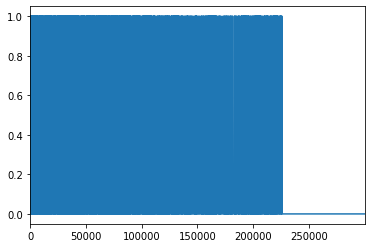

In [37]:
_ = pd.Series(ociosidade_classifier).plot()

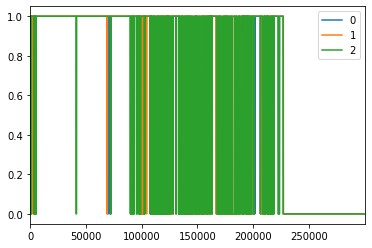

In [38]:
_ = pd.DataFrame(ociosidade_saborizador).plot()

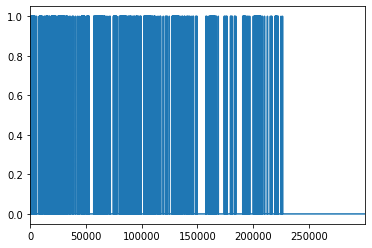

In [39]:
_ = pd.Series(ociosidade_embalador_Box).plot()

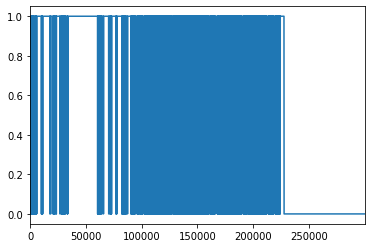

In [40]:
_ = pd.Series(ociosidade_embalador_Bag).plot()

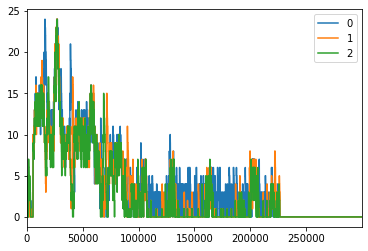

In [41]:
_ = pd.DataFrame(tamanho_da_fila_pfi).plot()

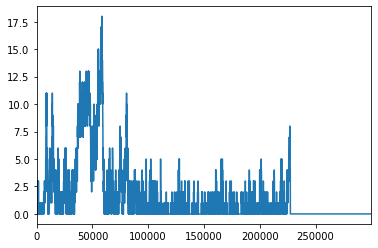

In [42]:
_ = pd.Series(tamanho_da_fila_bag).plot()

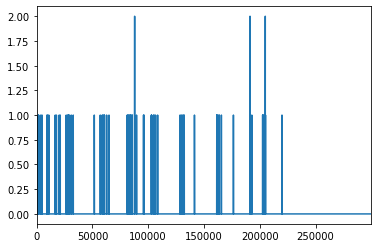

In [43]:
_ = pd.Series(tamanho_da_fila_box).plot()

In [44]:
teste2 = pd.DataFrame(classifier_balance, columns = ['Site', 'Color', 'Qty'])
teste2

,Site,Color,Qty
0,"Omaha, NE",Coloring Agent21,22632.000
1,"Omaha, NE",Coloring Agent21,0.000
2,"Omaha, NE",Coloring Agent21,0.000
3,"Omaha, NE",Coloring Agent21,0.000
4,"Omaha, NE",Coloring Agent21,0.000
...,...,...,...
3145,"Omaha, NE",Coloring Agent17,0.000
3146,"Omaha, NE",Coloring Agent17,0.000
3147,"Omaha, NE",Coloring Agent17,4203.621
3148,"Omaha, NE",Coloring Agent17,0.000


In [50]:
pd.DataFrame(workorder.groupby(['Plant Id','Color','Size','Flavor','Packaging Type']).sum()['Qty']).to_csv(factory+'_Team3234_InventoryBalance.csv',sep=';', decimal = ',')

In [45]:
workorder

,Plant Id,Internal Work Order Id,Color,Size,Flavor,Packaging Type,Qty,Stage,Produzido,Inicio,Fim,Dias,Custo
0,"Omaha, NE",ON215896,Coloring Agent21,S5,F2,Bag,3621.0,6,14484.0 bags,0.0,542.000000,0.15,3621.000
1,"Omaha, NE",ON215896,Coloring Agent21,S1,F2,Bag,3877.0,6,15508.0 bags,306.0,677.000000,0.10,3877.000
2,"Omaha, NE",ON215896,Coloring Agent21,S1,F4,Box,593.0,6,237.2 boxes,307.0,350.000000,0.01,565.722
3,"Omaha, NE",ON215896,Coloring Agent21,S2,F10,Bag,4378.0,6,17512.0 bags,308.0,796.000000,0.14,4378.000
4,"Omaha, NE",ON215896,Coloring Agent21,S3,F6,Bag,1937.0,6,7748.0 bags,309.0,719.000000,0.11,1937.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3204,"Omaha, NE",NaN,Coloring Agent31,S5,F3,Bag,2617.0,6,10468.0 bags,NaN,193849.434110,NaN,2617.000
3205,"Omaha, NE",NaN,Coloring Agent29,S5,F5,Bag,1230.0,6,4920.0 bags,NaN,195200.993897,NaN,1230.000
3206,"Omaha, NE",NaN,Coloring Agent29,S2,F5,Bag,4475.0,6,17900.0 bags,NaN,195643.373309,NaN,4475.000
3207,"Omaha, NE",ON304876,Coloring Agent30,S1,F3,Bag,1.0,99,,0.0,0.000000,0.00,0.000


In [46]:
pfi_drum_aux

,Capacity In pounds,Level,Cor,Size,Num
Drum Number,,,,,
PFI_Drum1,7500,0,,,0
PFI_Drum2,7500,0,,,1
PFI_Drum3,7500,0,,,2
PFI_Drum4,7500,532,Coloring Agent30,S4,3
PFI_Drum5,7500,0,,,4
PFI_Drum6,7500,546,Coloring Agent17,S4,5
PFI_Drum7,7500,0,,,6
PFI_Drum8,7500,0,,,7
PFI_Drum9,7500,0,,,8


In [47]:
pfi_eq_aux

,Sabor,Ocupado,Num,Ultimo_uso
PFI,,,,
PFI_1,F1,1,0,226328
PFI_2,F3,1,1,226775
PFI_3,F1,1,2,226526


In [48]:
fi_drum_aux

,Capacity,Level,Cor,Size,Flavor,Num
Drum Number,,,,,,
FI_Drum_1,17500,0,,,,0
FI_Drum_2,17500,0,,,,1
FI_Drum_3,17500,0,,,,2
FI_Drum_4,17500,0,,,,3
FI_Drum_5,17500,0,,,,4
FI_Drum_6,17500,0,,,,5
FI_Drum_7,17500,0,,,,6
FI_Drum_8,17500,0,,,,7
FI_Drum_9,17500,0,,,,8


In [49]:
#Predizer a falha em uma determinada cor:
#Para cada ordem, determinar o quanto será produzido dos 5 tamanhos, se ela necessitar de tamanho